# UK Energy Demand Prediction Using XGBoost (WIP)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import xgboost as xgb 
import os
import requests
import re
import shutil
import glob
import holidays

from statsmodels.graphics.tsaplots import plot_acf
from datetime import timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

In [78]:
# Step 0: Delete folder if it already exists to avoid duplication
save_dir = "neso_energy_demand_data"
if os.path.exists(save_dir):
    print(f"🧹 Removing existing directory: {save_dir}")
    shutil.rmtree(save_dir)

# Re-create the folder
os.makedirs(save_dir, exist_ok=True)

# Step 1: Query NESO API for data package info
api_url = "https://api.neso.energy/api/3/action/datapackage_show?id=historic-demand-data"
response = requests.get(api_url)

if response.status_code != 200:
    raise Exception(f"Failed to retrieve metadata from API: {response.status_code}")

data = response.json()

# Step 2: Extract URLs of CSV files
resources = data.get("result", {}).get("resources", [])
csv_resources = {
    res["name"]: res["path"]
    for res in resources
    if res.get("path", "").endswith(".csv")
}

# Step 3: Download each CSV file
for name, url in csv_resources.items():
    # Normalize filename
    filename = re.sub(r"[^\w\d_]+", "_", name.lower()) + ".csv"
    save_path = os.path.join(save_dir, filename)

    print(f"Downloading {filename} from {url}...")
    try:
        file_response = requests.get(url)
        file_response.raise_for_status()
        with open(save_path, "wb") as f:
            f.write(file_response.content)
    except Exception as e:
        print(f"❌ Failed to download {name}: {e}")

print(f"\n✅ Download complete. Files saved to '{save_dir}'")

🧹 Removing existing directory: neso_energy_demand_data

✅ Download complete. Files saved to 'neso_energy_demand_data'


In [4]:
# Path to directory containing CSVs
folder_path = 'neso_energy_demand_data'

# Get a list of all CSV file paths in the directory
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Read and concatenate all CSVs into one DataFrame
df_list = [pd.read_csv(file).assign(source=os.path.basename(file)) for file in csv_files]
df = pd.concat(df_list, ignore_index=True)

# Preview the combined data
print(f"✅ Loaded {len(csv_files)} CSV files.")
print(f"🧮 Combined rows: {len(df):,}")
print(df.head())
print(df.tail())

✅ Loaded 25 CSV files.
🧮 Combined rows: 430,270
  SETTLEMENT_DATE  SETTLEMENT_PERIOD     ND  TSD  ENGLAND_WALES_DEMAND  \
0      2001-01-01                  1  38631  NaN                 34060   
1      2001-01-01                  2  39808  NaN                 35370   
2      2001-01-01                  3  40039  NaN                 35680   
3      2001-01-01                  4  39339  NaN                 35029   
4      2001-01-01                  5  38295  NaN                 34047   

   EMBEDDED_WIND_GENERATION  EMBEDDED_WIND_CAPACITY  \
0                       NaN                     NaN   
1                       NaN                     NaN   
2                       NaN                     NaN   
3                       NaN                     NaN   
4                       NaN                     NaN   

   EMBEDDED_SOLAR_GENERATION  EMBEDDED_SOLAR_CAPACITY  NON_BM_STOR  ...  \
0                        NaN                      NaN            0  ...   
1                        N

In [5]:
def build_settlement_datetime(df, date_col='SETTLEMENT_DATE', period_col='SETTLEMENT_PERIOD'):
    out = df.copy()

    # Date only
    out[date_col] = pd.to_datetime(out[date_col]).dt.normalize()

    # 46/48/50 periods per day
    periods_per_day = out.groupby(out[date_col])[period_col].transform('max')
    p = out[period_col].astype(int)

    # Base minutes from midnight
    base_min = (p - 1) * 30

    # Adjust for clock changes
    adj_min = np.where((periods_per_day == 50) & (p >= 5), base_min - 60,     # fall-back
              np.where((periods_per_day == 46) & (p >= 3), base_min + 60,     # spring-forward
                       base_min))

    # Build naive local wall-clock datetimes
    dt_local_naive = out[date_col] + pd.to_timedelta(adj_min, unit='m')

    # Localize to Europe/London, disambiguate the fall-back hour, then convert to UTC
    dt_local = pd.DatetimeIndex(dt_local_naive).tz_localize(
        'Europe/London', ambiguous='infer', nonexistent='shift_forward'
    )
    out['SETTLEMENT_DATETIME'] = dt_local.tz_convert('UTC')

    return out

In [6]:
df = build_settlement_datetime(df, 'SETTLEMENT_DATE', 'SETTLEMENT_PERIOD')
df = df.set_index('SETTLEMENT_DATETIME').sort_index()

# sanity checks
print(df.index.dtype)          # should show datetime64[ns, UTC]
print(df.index.is_unique)      # should be True

datetime64[ns, UTC]
True


In [7]:
print(df.head())

                          SETTLEMENT_DATE  SETTLEMENT_PERIOD     ND  TSD  \
SETTLEMENT_DATETIME                                                        
2001-01-01 00:00:00+00:00      2001-01-01                  1  38631  NaN   
2001-01-01 00:30:00+00:00      2001-01-01                  2  39808  NaN   
2001-01-01 01:00:00+00:00      2001-01-01                  3  40039  NaN   
2001-01-01 01:30:00+00:00      2001-01-01                  4  39339  NaN   
2001-01-01 02:00:00+00:00      2001-01-01                  5  38295  NaN   

                           ENGLAND_WALES_DEMAND  EMBEDDED_WIND_GENERATION  \
SETTLEMENT_DATETIME                                                         
2001-01-01 00:00:00+00:00                 34060                       NaN   
2001-01-01 00:30:00+00:00                 35370                       NaN   
2001-01-01 01:00:00+00:00                 35680                       NaN   
2001-01-01 01:30:00+00:00                 35029                       NaN   
2001-

In [8]:
df = df[['ND']]

print(df.head())

                              ND
SETTLEMENT_DATETIME             
2001-01-01 00:00:00+00:00  38631
2001-01-01 00:30:00+00:00  39808
2001-01-01 01:00:00+00:00  40039
2001-01-01 01:30:00+00:00  39339
2001-01-01 02:00:00+00:00  38295


In [9]:
df.tail()

ND
SETTLEMENT_DATETIME             
2025-07-17 20:30:00+00:00  27873
2025-07-17 21:00:00+00:00  27035
2025-07-17 21:30:00+00:00  25710
2025-07-17 22:00:00+00:00  24176
2025-07-17 22:30:00+00:00  23467

In [10]:
df['ND'].isnull().any()

False

In [11]:
# Boolean mask of which index entries are duplicates
mask = df.index.duplicated(keep=False)

# Show only the duplicate rows
duplicates = df[mask]

# See just the duplicate index values (unique)
duplicate_times = df.index[df.index.duplicated()].unique()

print("Duplicate timestamps found:", len(duplicate_times))
print(duplicate_times)

Duplicate timestamps found: 0
DatetimeIndex([], dtype='datetime64[ns, UTC]', name='SETTLEMENT_DATETIME', freq=None)


<Axes: title={'center': 'Great Britain National Demand in MW'}, xlabel='Date', ylabel='MW'>

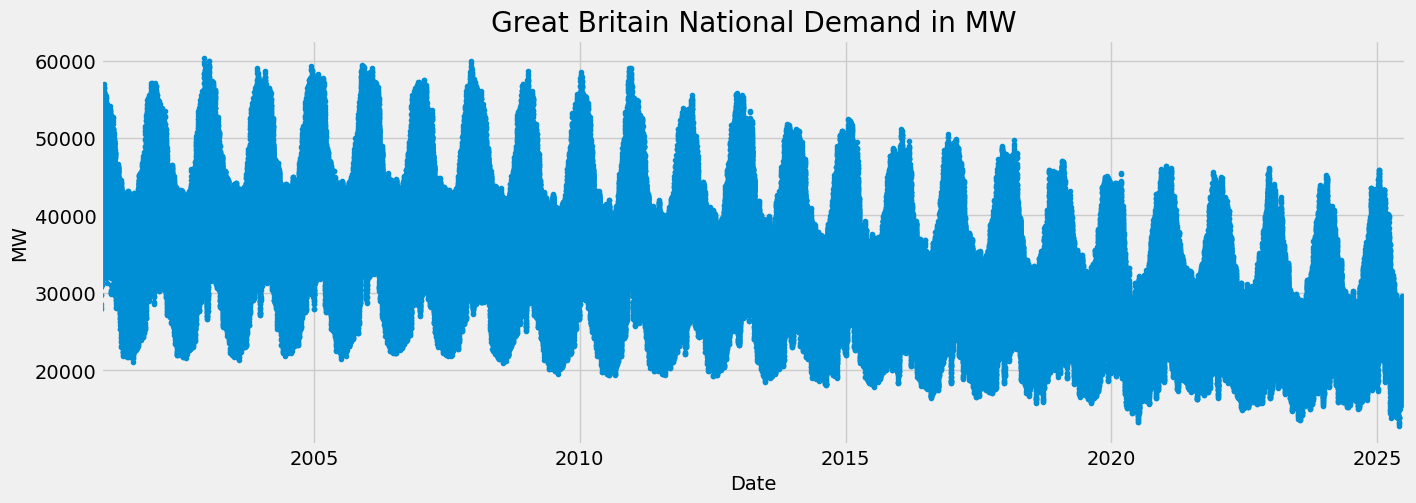

In [12]:
df['ND'].plot(style='.', 
        figsize=(15, 5), 
        color = color_pal[0], 
        title = 'Great Britain National Demand in MW', 
        xlabel = 'Date',
        ylabel = 'MW'
       )

Text(0, 0.5, 'Frequency')

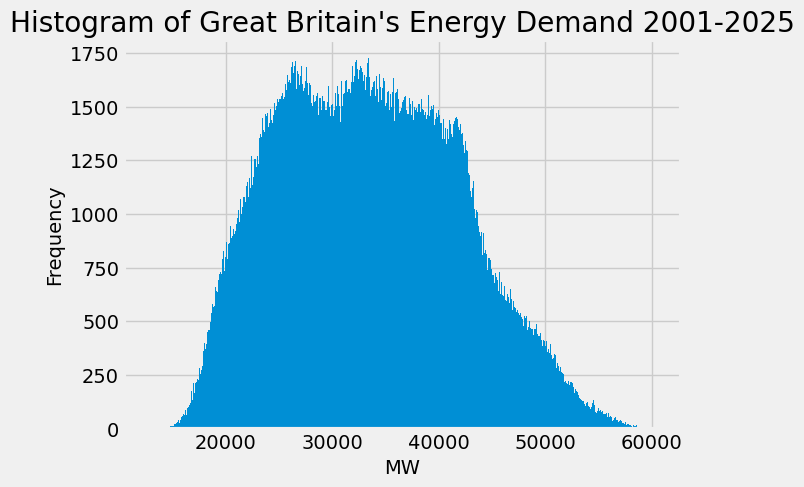

In [13]:
df['ND'].plot(kind='hist', bins=500, title="Histogram of Great Britain's Energy Demand 2001-2025")
plt.xlabel('MW')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

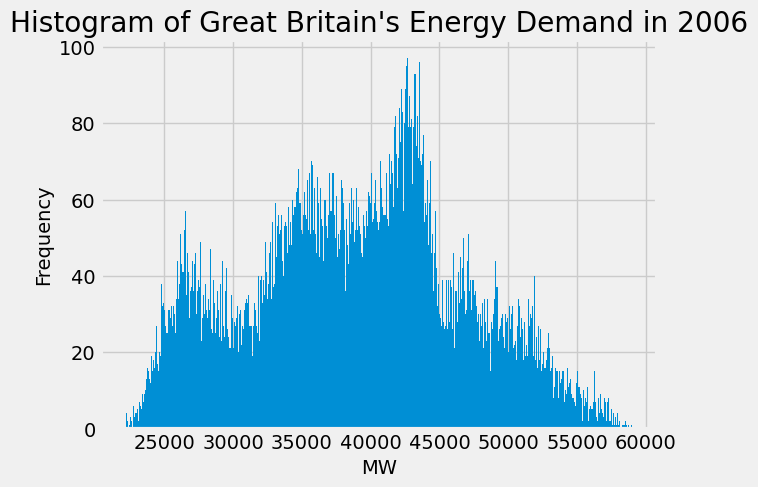

In [14]:
df.loc['2006', 'ND'].plot(kind='hist', bins=500, title="Histogram of Great Britain's Energy Demand in 2006")
plt.xlabel('MW')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

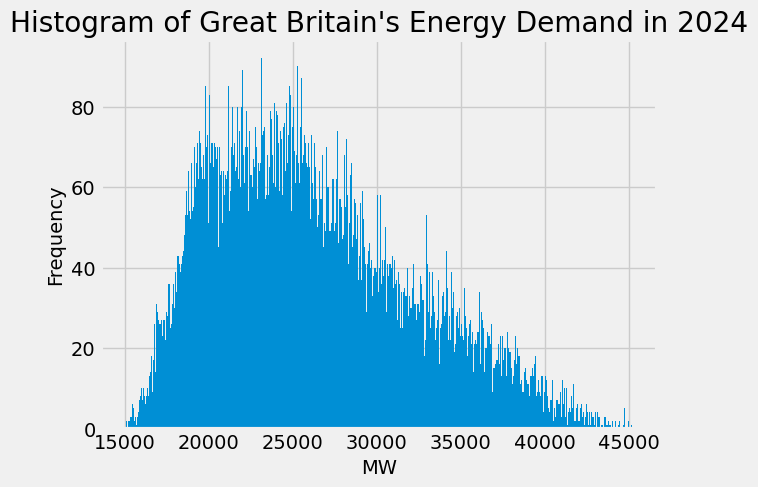

In [15]:
df.loc['2024', 'ND'].plot(kind='hist', bins=500, title="Histogram of Great Britain's Energy Demand in 2024")
plt.xlabel('MW')
plt.ylabel('Frequency')

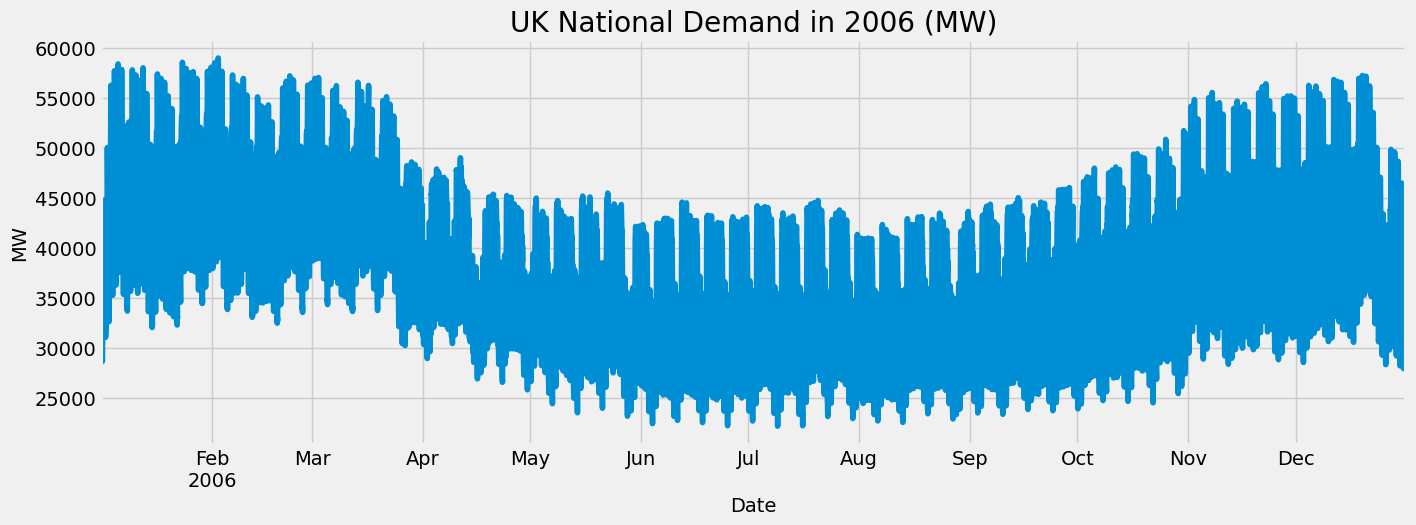

In [16]:
df.loc[(df.index > '2006-01-01') & (df.index < '2007-01-01')]['ND'] \
    .plot(figsize=(15, 5), title='UK National Demand in 2006 (MW)', xlabel = 'Date', ylabel = 'MW')
plt.show()

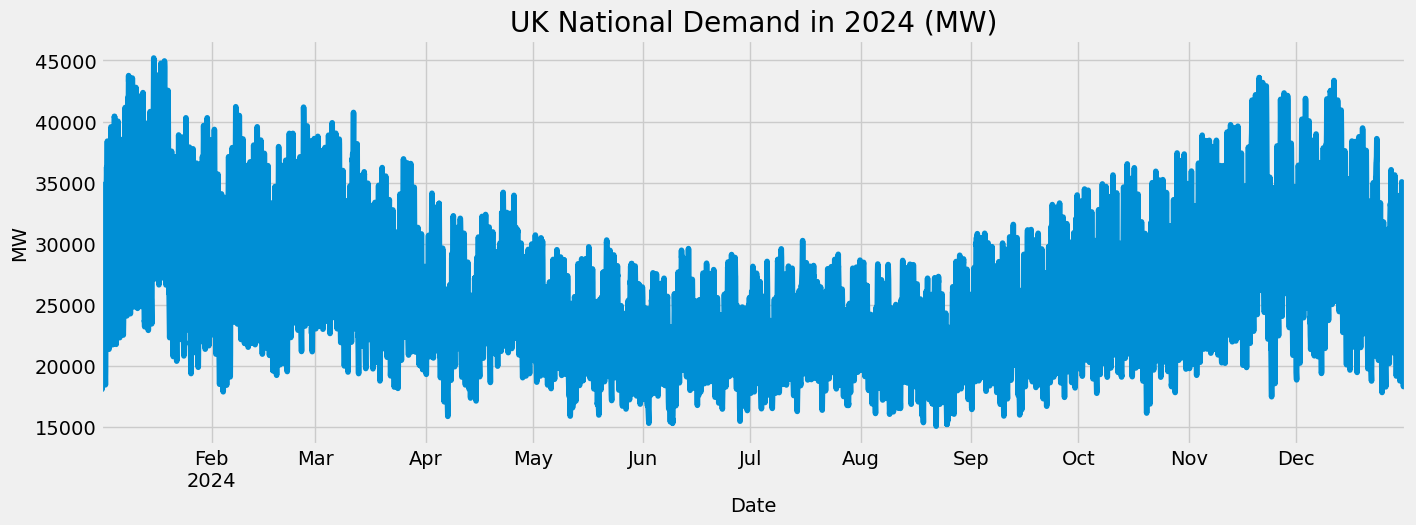

In [17]:
df.loc[(df.index > '2024-01-01') & (df.index < '2025-01-01')]['ND'] \
    .plot(figsize=(15, 5), title='UK National Demand in 2024 (MW)', xlabel = 'Date', ylabel = 'MW')
plt.show()

<Axes: title={'center': 'Potential Bottom End Outliers'}, xlabel='SETTLEMENT_DATETIME'>

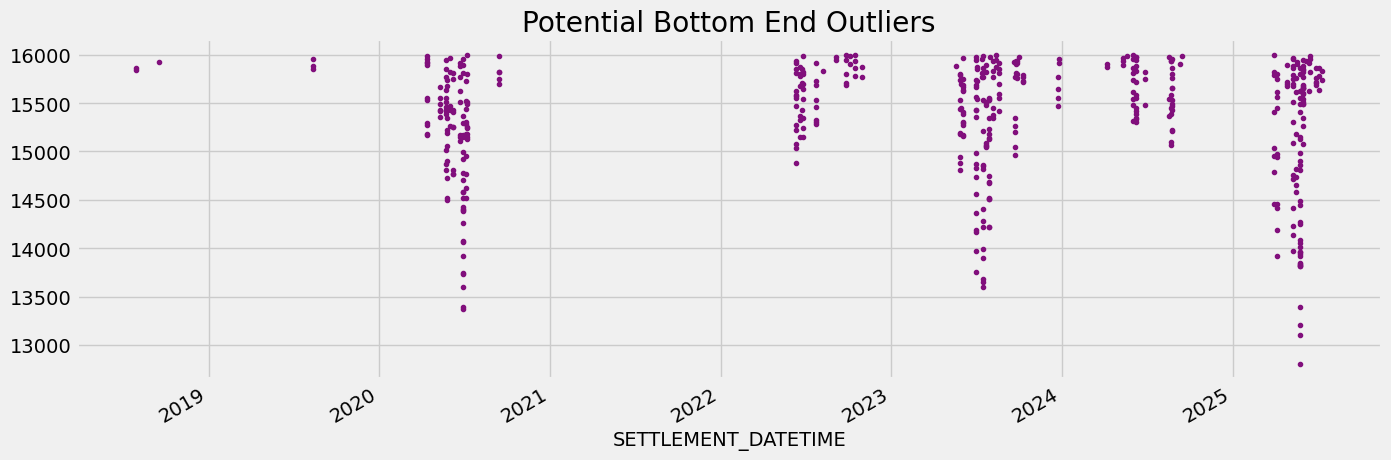

In [18]:
df.query('ND < 16000')['ND'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Potential Bottom End Outliers')

<Axes: title={'center': 'Potential Top End Outliers'}, xlabel='SETTLEMENT_DATETIME'>

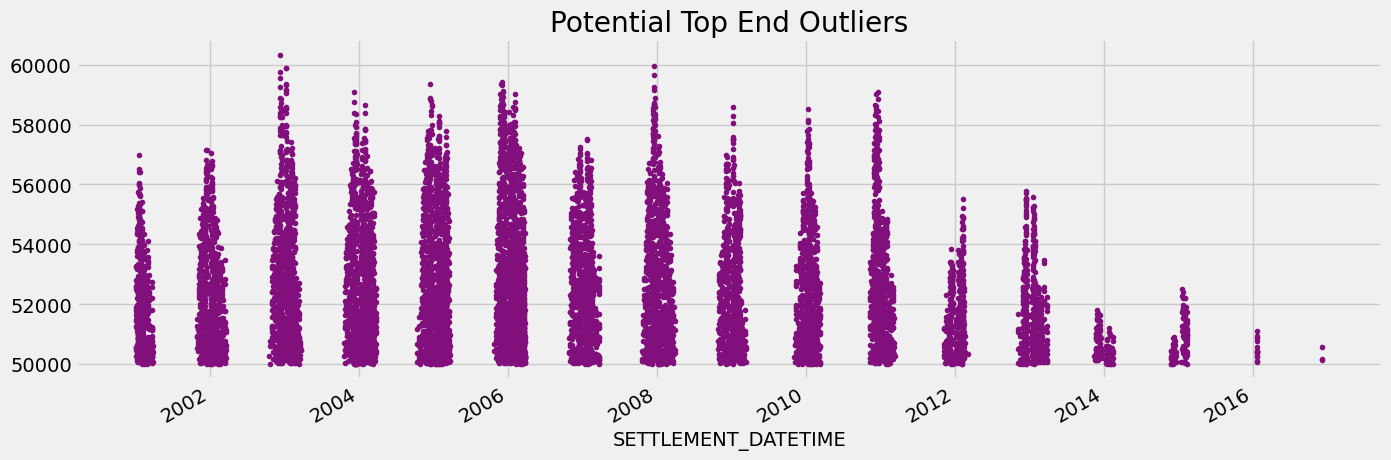

In [19]:
df.query('ND > 50000')['ND'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Potential Top End Outliers')

Although we do have some exceptionally low points of energy demand such as in 2025 when it drops below 13,000MW once, and in 2003 when it creeps above 60,000MW once, these look like genuine data points following the trends of the times of year. As such, and also because of the reliability and frequently updated nature of the NESO data, although it is good to be aware of these points we will not take any action to remove them as outliers at this time.

<Axes: xlabel='SETTLEMENT_DATETIME'>

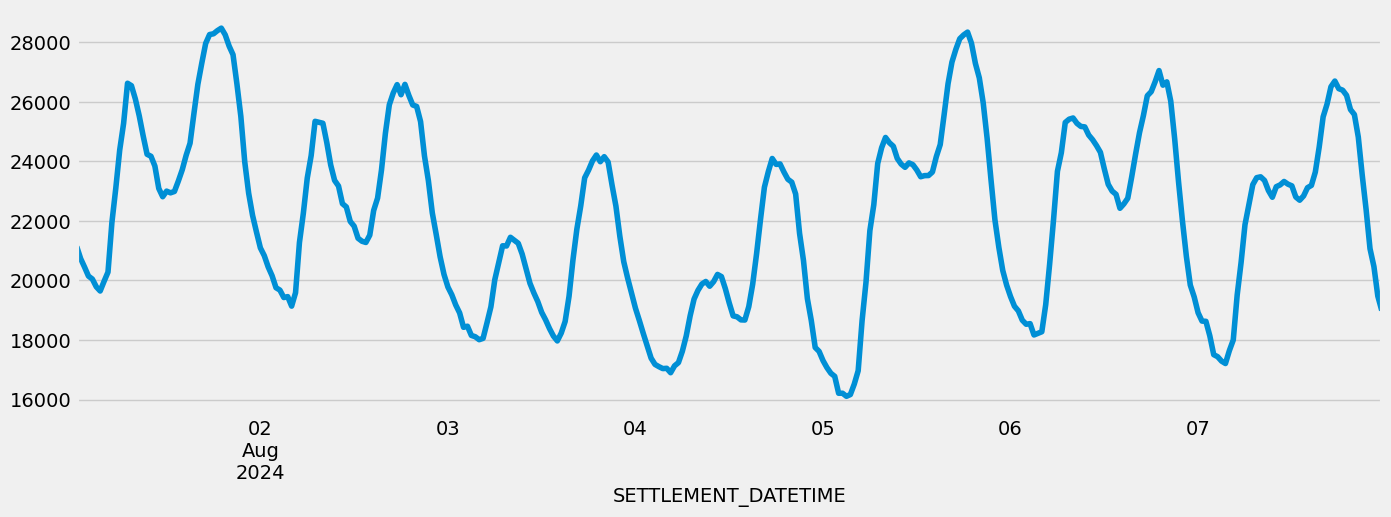

In [20]:
df.loc[(df.index > '2024-08-01') & (df.index < '2024-08-08')]['ND'].plot(figsize=(15, 5))

In [21]:
def create_calendar_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour']        = df.index.hour
    df['minute']      = df.index.minute
    df['day_of_week']   = df.index.dayofweek           # Mon=0 ... Sun=6
    df['is_weekend']  = df['day_of_week'] >= 5
    df['quarter']     = df.index.quarter
    df['month']       = df.index.month
    df['year']        = df.index.year
    df['day_of_year']   = df.index.dayofyear
    df['day_of_month']  = df.index.day
    df['week_of_year']  = df.index.isocalendar().week.astype(int)
    df['settlement_period'] = (df['hour'] * 2 + (df['minute'] // 30)) + 1
    df['half_hour_label'] = df.index.strftime('%H:%M')
    
    # Cyclical encoding for settlement_period
    max_sp = df['settlement_period'].max()
    df['sp_sin'] = np.sin(2 * np.pi * df['settlement_period'] / max_sp)
    df['sp_cos'] = np.cos(2 * np.pi * df['settlement_period'] / max_sp)

    # Holiday flag
    uk_holidays = holidays.UnitedKingdom()
    
    df['holiday_name'] = (
    df.index.tz_convert(None)
      .normalize()
      .map(lambda d: uk_holidays.get(d))
    )
    
    df['is_holiday'] = df['holiday_name'].notna()

    return df

df = create_calendar_features(df)

In [22]:
df.head()

ND  hour  minute  day_of_week  is_weekend  \
SETTLEMENT_DATETIME                                                       
2001-01-01 00:00:00+00:00  38631     0       0            0       False   
2001-01-01 00:30:00+00:00  39808     0      30            0       False   
2001-01-01 01:00:00+00:00  40039     1       0            0       False   
2001-01-01 01:30:00+00:00  39339     1      30            0       False   
2001-01-01 02:00:00+00:00  38295     2       0            0       False   

                           quarter  month  year  day_of_year  day_of_month  \
SETTLEMENT_DATETIME                                                          
2001-01-01 00:00:00+00:00        1      1  2001            1             1   
2001-01-01 00:30:00+00:00        1      1  2001            1             1   
2001-01-01 01:00:00+00:00        1      1  2001            1             1   
2001-01-01 01:30:00+00:00        1      1  2001            1             1   
2001-01-01 02:00:00+00:00        1      1  2001            1             1   

                           week_of_year  settlement_period half_hour_label  \
SETTLEMENT_DATETIME                                                          
2001-01-01 00:00:00+00:00             1                  1           00:00   
2001-01-01 00:30:00+00:00             1                  2           00:30   
2001-01-01 01:00:00+00:00             1                  3           01:00   
2001-01-01 01:30:00+00:00             1                  4           01:30   
2001-01-01 02:00:00+00:00             1                  5           02:00   

                             sp_sin    sp_cos    holiday_name  is_holiday  
SETTLEMENT_DATETIME                                                        
2001-01-01 00:00:00+00:00  0.130526  0.991445  New Year's Day        True  
2001-01-01 00:30:00+00:00  0.258819  0.965926  New Year's Day        True  
2001-01-01 01:00:00+00:00  0.382683  0.923880  New Year's Day        True  
2001-01-01 01:30:00+00:00  0.500000  0.866025  New Year's Day        True  
2001-01-01 02:00:00+00:00  0.608761  0.793353  New Year's Day        True

In [23]:
def add_calendar_lags(df, target_col='ND', years=(1, 2, 3, 4, 5), method='exact', tolerance='15min'):
    """
    Add y-years-ago lag features aligned on calendar date & wall-clock time.
    - Uses pd.DateOffset(years=y) so leap years are handled.
    - If `method='exact'`, only exact timestamp matches are used; others are NaN.
    - If `method='nearest'`, the nearest timestamp within `tolerance` is used.
    """
    df = df.copy()
    s = df[target_col]

    for y in years:
        lag_idx = df.index - pd.DateOffset(years=y)
        col = f'ND_exactly_{y}_years_ago'
        if method == 'exact':
            # exact label match; no fill if missing
            df[col] = s.reindex(lag_idx).to_numpy()
        elif method == 'nearest':
            # nearest match within a tolerance (useful around DST glitches)
            df[col] = s.reindex(lag_idx, method='nearest', tolerance=tolerance).to_numpy()
        else:
            raise ValueError("method must be 'exact' or 'nearest'")

    return df

# Example:
# df = add_calendar_lags(df, target_col='ND', years=(1,2,3), method='exact'

In [24]:
df = add_calendar_lags(df, target_col='ND', years=(1,2,3,4,5), method='exact')

In [25]:
df.head()

ND  hour  minute  day_of_week  is_weekend  \
SETTLEMENT_DATETIME                                                       
2001-01-01 00:00:00+00:00  38631     0       0            0       False   
2001-01-01 00:30:00+00:00  39808     0      30            0       False   
2001-01-01 01:00:00+00:00  40039     1       0            0       False   
2001-01-01 01:30:00+00:00  39339     1      30            0       False   
2001-01-01 02:00:00+00:00  38295     2       0            0       False   

                           quarter  month  year  day_of_year  day_of_month  \
SETTLEMENT_DATETIME                                                          
2001-01-01 00:00:00+00:00        1      1  2001            1             1   
2001-01-01 00:30:00+00:00        1      1  2001            1             1   
2001-01-01 01:00:00+00:00        1      1  2001            1             1   
2001-01-01 01:30:00+00:00        1      1  2001            1             1   
2001-01-01 02:00:00+00:00        1      1  2001            1             1   

                           ...  half_hour_label    sp_sin    sp_cos  \
SETTLEMENT_DATETIME        ...                                        
2001-01-01 00:00:00+00:00  ...            00:00  0.130526  0.991445   
2001-01-01 00:30:00+00:00  ...            00:30  0.258819  0.965926   
2001-01-01 01:00:00+00:00  ...            01:00  0.382683  0.923880   
2001-01-01 01:30:00+00:00  ...            01:30  0.500000  0.866025   
2001-01-01 02:00:00+00:00  ...            02:00  0.608761  0.793353   

                             holiday_name  is_holiday ND_exactly_1_years_ago  \
SETTLEMENT_DATETIME                                                            
2001-01-01 00:00:00+00:00  New Year's Day        True                    NaN   
2001-01-01 00:30:00+00:00  New Year's Day        True                    NaN   
2001-01-01 01:00:00+00:00  New Year's Day        True                    NaN   
2001-01-01 01:30:00+00:00  New Year's Day        True                    NaN   
2001-01-01 02:00:00+00:00  New Year's Day        True                    NaN   

                           ND_exactly_2_years_ago  ND_exactly_3_years_ago  \
SETTLEMENT_DATETIME                                                         
2001-01-01 00:00:00+00:00                     NaN                     NaN   
2001-01-01 00:30:00+00:00                     NaN                     NaN   
2001-01-01 01:00:00+00:00                     NaN                     NaN   
2001-01-01 01:30:00+00:00                     NaN                     NaN   
2001-01-01 02:00:00+00:00                     NaN                     NaN   

                           ND_exactly_4_years_ago  ND_exactly_5_years_ago  
SETTLEMENT_DATETIME                                                        
2001-01-01 00:00:00+00:00                     NaN                     NaN  
2001-01-01 00:30:00+00:00                     NaN                     NaN  
2001-01-01 01:00:00+00:00                     NaN                     NaN  
2001-01-01 01:30:00+00:00                     NaN                     NaN  
2001-01-01 02:00:00+00:00                     NaN                     NaN  

[5 rows x 22 columns]

In [26]:
df.tail()

ND  hour  minute  day_of_week  is_weekend  \
SETTLEMENT_DATETIME                                                       
2025-07-17 20:30:00+00:00  27873    20      30            3       False   
2025-07-17 21:00:00+00:00  27035    21       0            3       False   
2025-07-17 21:30:00+00:00  25710    21      30            3       False   
2025-07-17 22:00:00+00:00  24176    22       0            3       False   
2025-07-17 22:30:00+00:00  23467    22      30            3       False   

                           quarter  month  year  day_of_year  day_of_month  \
SETTLEMENT_DATETIME                                                          
2025-07-17 20:30:00+00:00        3      7  2025          198            17   
2025-07-17 21:00:00+00:00        3      7  2025          198            17   
2025-07-17 21:30:00+00:00        3      7  2025          198            17   
2025-07-17 22:00:00+00:00        3      7  2025          198            17   
2025-07-17 22:30:00+00:00        3      7  2025          198            17   

                           ...  half_hour_label    sp_sin    sp_cos  \
SETTLEMENT_DATETIME        ...                                        
2025-07-17 20:30:00+00:00  ...            20:30 -0.707107  0.707107   
2025-07-17 21:00:00+00:00  ...            21:00 -0.608761  0.793353   
2025-07-17 21:30:00+00:00  ...            21:30 -0.500000  0.866025   
2025-07-17 22:00:00+00:00  ...            22:00 -0.382683  0.923880   
2025-07-17 22:30:00+00:00  ...            22:30 -0.258819  0.965926   

                           holiday_name  is_holiday ND_exactly_1_years_ago  \
SETTLEMENT_DATETIME                                                          
2025-07-17 20:30:00+00:00          None       False                26862.0   
2025-07-17 21:00:00+00:00          None       False                25908.0   
2025-07-17 21:30:00+00:00          None       False                24826.0   
2025-07-17 22:00:00+00:00          None       False                23194.0   
2025-07-17 22:30:00+00:00          None       False                21835.0   

                           ND_exactly_2_years_ago  ND_exactly_3_years_ago  \
SETTLEMENT_DATETIME                                                         
2025-07-17 20:30:00+00:00                 25193.0                 25507.0   
2025-07-17 21:00:00+00:00                 24469.0                 25087.0   
2025-07-17 21:30:00+00:00                 23814.0                 24150.0   
2025-07-17 22:00:00+00:00                 22155.0                 23012.0   
2025-07-17 22:30:00+00:00                 21326.0                 21883.0   

                           ND_exactly_4_years_ago  ND_exactly_5_years_ago  
SETTLEMENT_DATETIME                                                        
2025-07-17 20:30:00+00:00                 26289.0                 26585.0  
2025-07-17 21:00:00+00:00                 25745.0                 25977.0  
2025-07-17 21:30:00+00:00                 24998.0                 24850.0  
2025-07-17 22:00:00+00:00                 23971.0                 23315.0  
2025-07-17 22:30:00+00:00                 22630.0                 21846.0  

[5 rows x 22 columns]

In [27]:
df.loc[(df.index > '2024-08-01') & (df.index < '2024-08-08')]

ND  hour  minute  day_of_week  is_weekend  \
SETTLEMENT_DATETIME                                                       
2024-08-01 00:30:00+00:00  21139     0      30            3       False   
2024-08-01 01:00:00+00:00  20735     1       0            3       False   
2024-08-01 01:30:00+00:00  20450     1      30            3       False   
2024-08-01 02:00:00+00:00  20148     2       0            3       False   
2024-08-01 02:30:00+00:00  20048     2      30            3       False   
...                          ...   ...     ...          ...         ...   
2024-08-07 21:30:00+00:00  22384    21      30            2       False   
2024-08-07 22:00:00+00:00  21068    22       0            2       False   
2024-08-07 22:30:00+00:00  20468    22      30            2       False   
2024-08-07 23:00:00+00:00  19476    23       0            2       False   
2024-08-07 23:30:00+00:00  18994    23      30            2       False   

                           quarter  month  year  day_of_year  day_of_month  \
SETTLEMENT_DATETIME                                                          
2024-08-01 00:30:00+00:00        3      8  2024          214             1   
2024-08-01 01:00:00+00:00        3      8  2024          214             1   
2024-08-01 01:30:00+00:00        3      8  2024          214             1   
2024-08-01 02:00:00+00:00        3      8  2024          214             1   
2024-08-01 02:30:00+00:00        3      8  2024          214             1   
...                            ...    ...   ...          ...           ...   
2024-08-07 21:30:00+00:00        3      8  2024          220             7   
2024-08-07 22:00:00+00:00        3      8  2024          220             7   
2024-08-07 22:30:00+00:00        3      8  2024          220             7   
2024-08-07 23:00:00+00:00        3      8  2024          220             7   
2024-08-07 23:30:00+00:00        3      8  2024          220             7   

                           ...  half_hour_label        sp_sin    sp_cos  \
SETTLEMENT_DATETIME        ...                                            
2024-08-01 00:30:00+00:00  ...            00:30  2.588190e-01  0.965926   
2024-08-01 01:00:00+00:00  ...            01:00  3.826834e-01  0.923880   
2024-08-01 01:30:00+00:00  ...            01:30  5.000000e-01  0.866025   
2024-08-01 02:00:00+00:00  ...            02:00  6.087614e-01  0.793353   
2024-08-01 02:30:00+00:00  ...            02:30  7.071068e-01  0.707107   
...                        ...              ...           ...       ...   
2024-08-07 21:30:00+00:00  ...            21:30 -5.000000e-01  0.866025   
2024-08-07 22:00:00+00:00  ...            22:00 -3.826834e-01  0.923880   
2024-08-07 22:30:00+00:00  ...            22:30 -2.588190e-01  0.965926   
2024-08-07 23:00:00+00:00  ...            23:00 -1.305262e-01  0.991445   
2024-08-07 23:30:00+00:00  ...            23:30 -2.449294e-16  1.000000   

                           holiday_name  is_holiday ND_exactly_1_years_ago  \
SETTLEMENT_DATETIME                                                          
2024-08-01 00:30:00+00:00          None       False                17591.0   
2024-08-01 01:00:00+00:00          None       False                17310.0   
2024-08-01 01:30:00+00:00          None       False                16812.0   
2024-08-01 02:00:00+00:00          None       False                16744.0   
2024-08-01 02:30:00+00:00          None       False                16608.0   
...                                 ...         ...                    ...   
2024-08-07 21:30:00+00:00          None       False                22486.0   
2024-08-07 22:00:00+00:00          None       False                21232.0   
2024-08-07 22:30:00+00:00          None       False                19936.0   
2024-08-07 23:00:00+00:00          None       False                19281.0   
2024-08-07 23:30:00+00:00          None       False                18680.0   

                           ND_exactly_2_years_ag

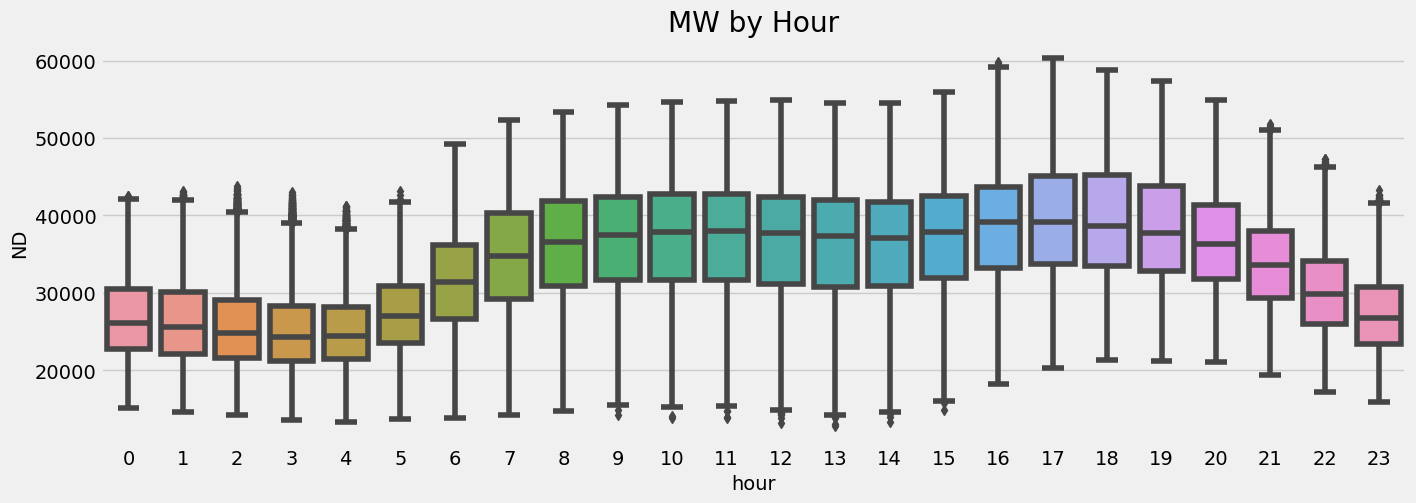

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x='hour', y='ND')
ax.set_title('MW by Hour')
plt.show()

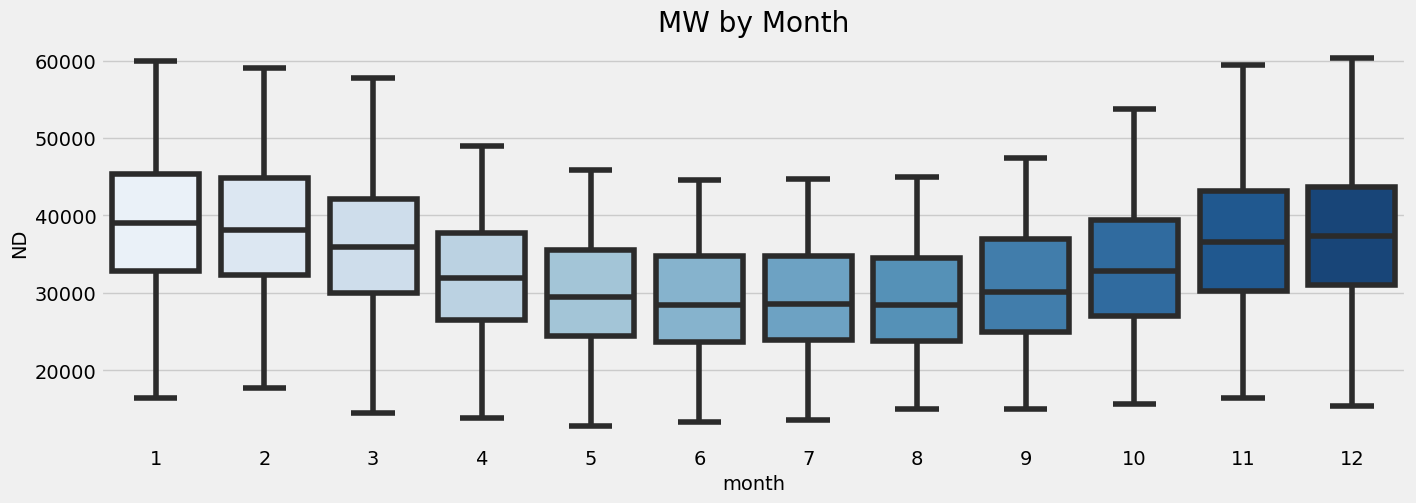

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x='month', y='ND', palette = 'Blues')
ax.set_title('MW by Month')
plt.show()

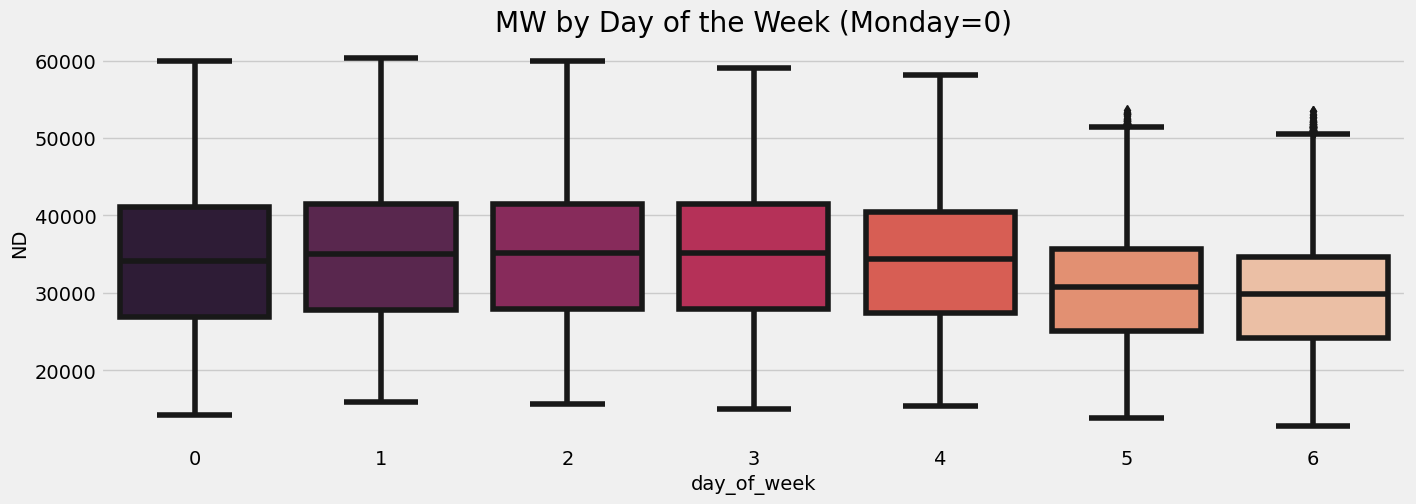

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x='day_of_week', y='ND', palette = 'rocket')
ax.set_title('MW by Day of the Week (Monday=0)')
plt.show()

[0]	validation_0-rmse:35718.29421	validation_1-rmse:28636.74657
[100]	validation_0-rmse:13496.06412	validation_1-rmse:10628.36532
[200]	validation_0-rmse:5679.63853	validation_1-rmse:4878.22632
[300]	validation_0-rmse:3237.48283	validation_1-rmse:3655.63669
[400]	validation_0-rmse:2567.63732	validation_1-rmse:3336.01328
[500]	validation_0-rmse:2366.30403	validation_1-rmse:3268.15436
[587]	validation_0-rmse:2280.88883	validation_1-rmse:3324.22695
Fold 1: RMSE=3262.89, MAPE=9.33%


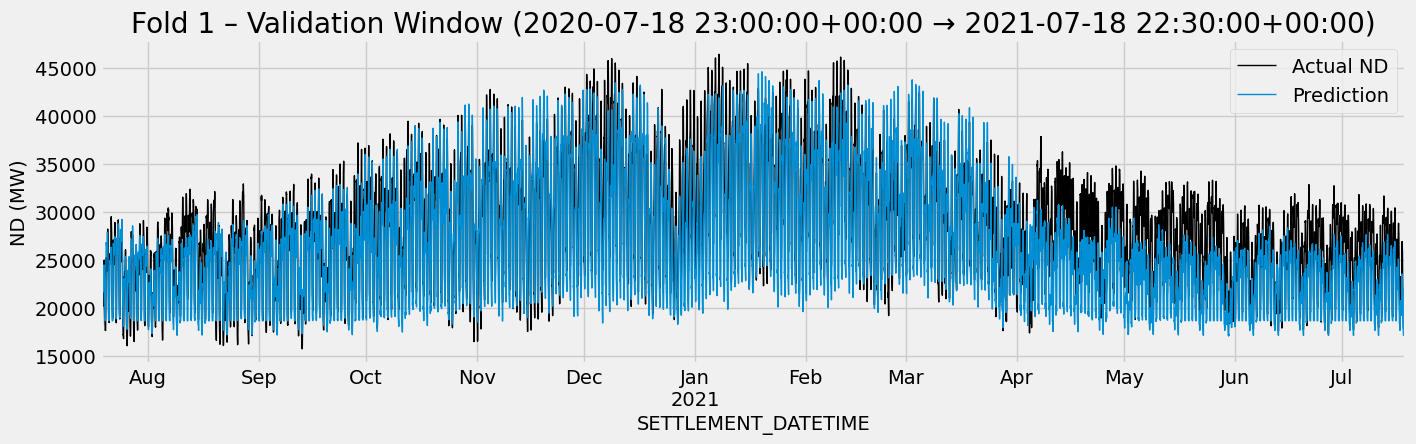

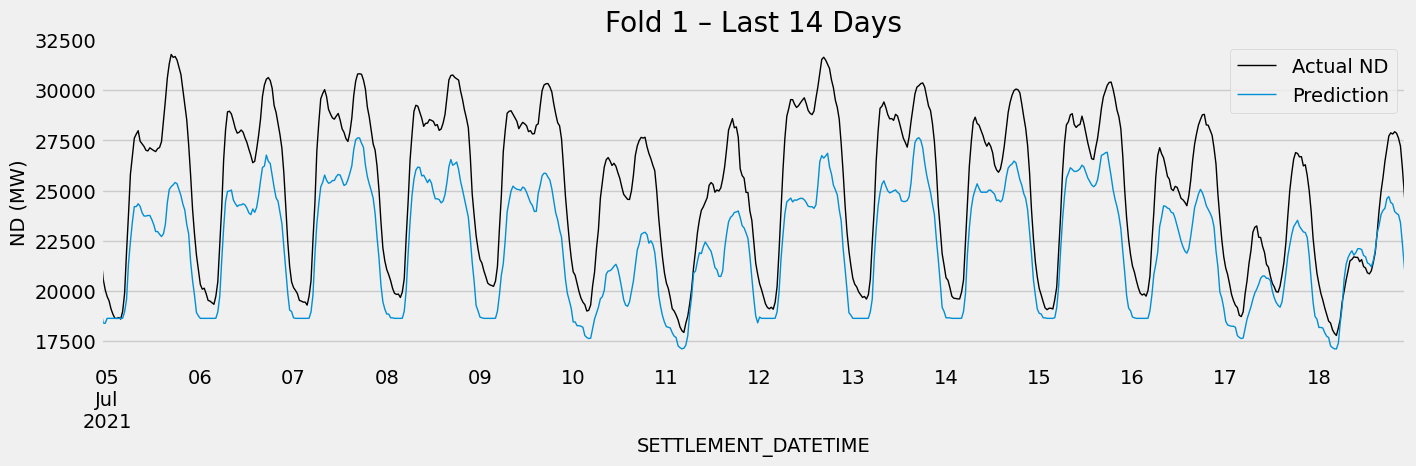

[0]	validation_0-rmse:35406.74444	validation_1-rmse:27910.41093
[100]	validation_0-rmse:13380.84942	validation_1-rmse:10059.68131
[200]	validation_0-rmse:5641.49488	validation_1-rmse:4124.80035
[300]	validation_0-rmse:3244.35910	validation_1-rmse:2543.13515
[400]	validation_0-rmse:2598.80562	validation_1-rmse:2226.83869
[500]	validation_0-rmse:2406.55826	validation_1-rmse:2169.37907
[600]	validation_0-rmse:2314.39104	validation_1-rmse:2167.20220
[607]	validation_0-rmse:2308.13452	validation_1-rmse:2170.09432
Fold 2: RMSE=2163.03, MAPE=6.42%


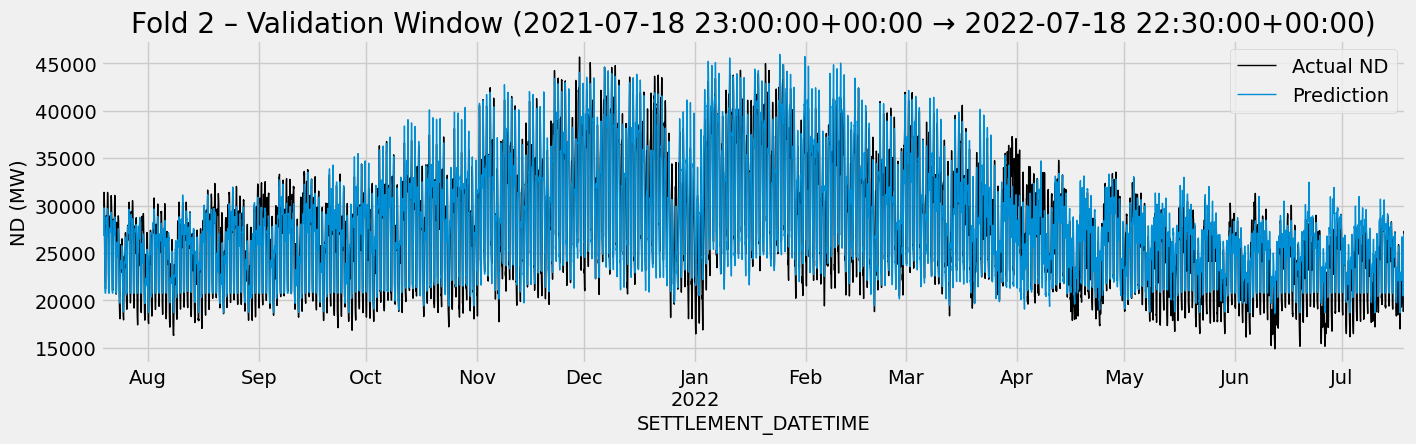

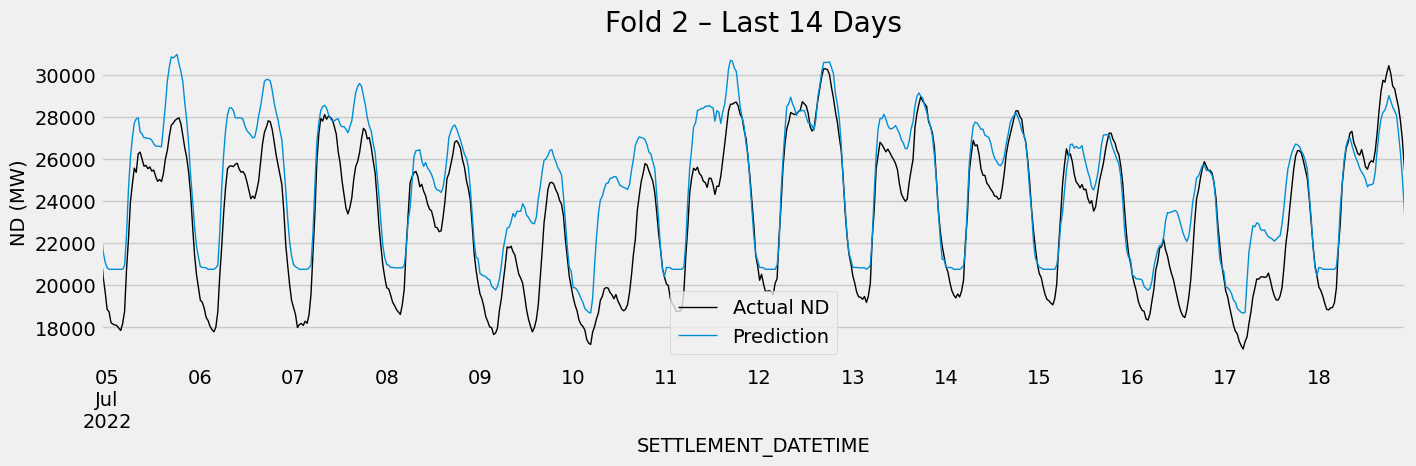

[0]	validation_0-rmse:35094.43484	validation_1-rmse:26534.42873
[100]	validation_0-rmse:13264.12543	validation_1-rmse:8996.71060
[200]	validation_0-rmse:5593.14594	validation_1-rmse:3349.51401
[300]	validation_0-rmse:3223.74583	validation_1-rmse:2320.81379
[381]	validation_0-rmse:2658.39856	validation_1-rmse:2323.12895
Fold 3: RMSE=2296.50, MAPE=7.12%


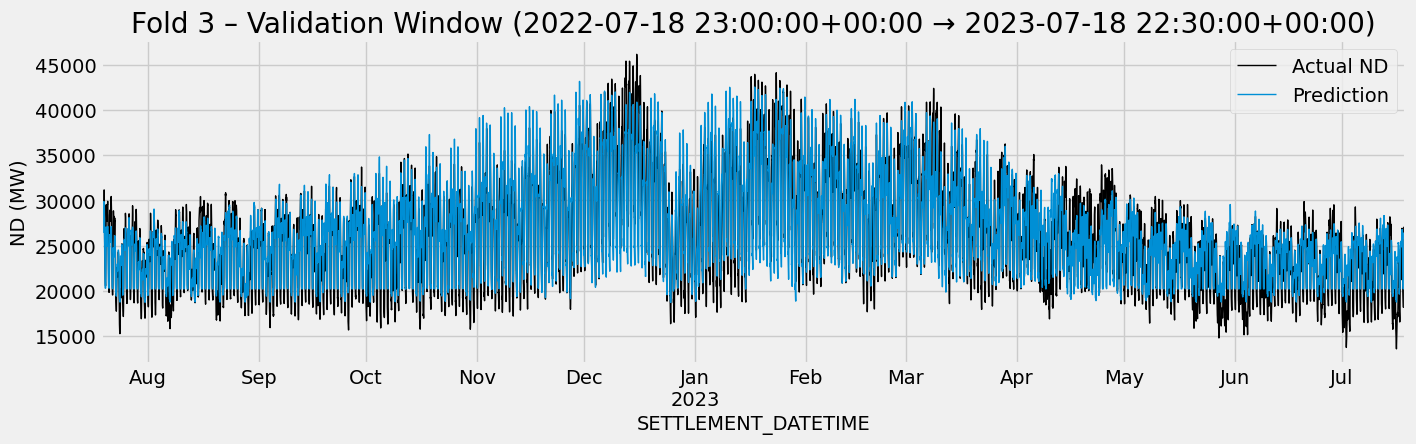

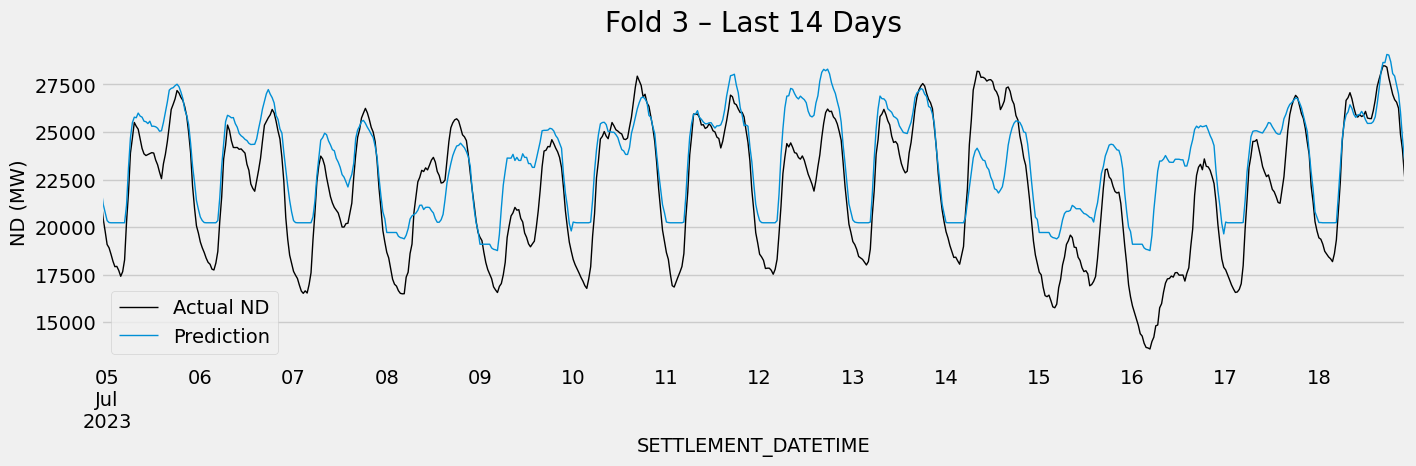

[0]	validation_0-rmse:34760.32467	validation_1-rmse:26492.83589
[100]	validation_0-rmse:13143.26492	validation_1-rmse:9676.96020
[200]	validation_0-rmse:5549.54224	validation_1-rmse:4101.44416
[300]	validation_0-rmse:3213.32872	validation_1-rmse:2681.24652
[400]	validation_0-rmse:2590.96519	validation_1-rmse:2390.16404
[500]	validation_0-rmse:2405.44978	validation_1-rmse:2322.12762
[600]	validation_0-rmse:2315.80511	validation_1-rmse:2288.27586
[700]	validation_0-rmse:2253.24634	validation_1-rmse:2278.02048
[800]	validation_0-rmse:2200.38063	validation_1-rmse:2271.50229
[900]	validation_0-rmse:2157.76172	validation_1-rmse:2267.65995
[999]	validation_0-rmse:2121.90837	validation_1-rmse:2267.12887
Fold 4: RMSE=2264.19, MAPE=6.71%


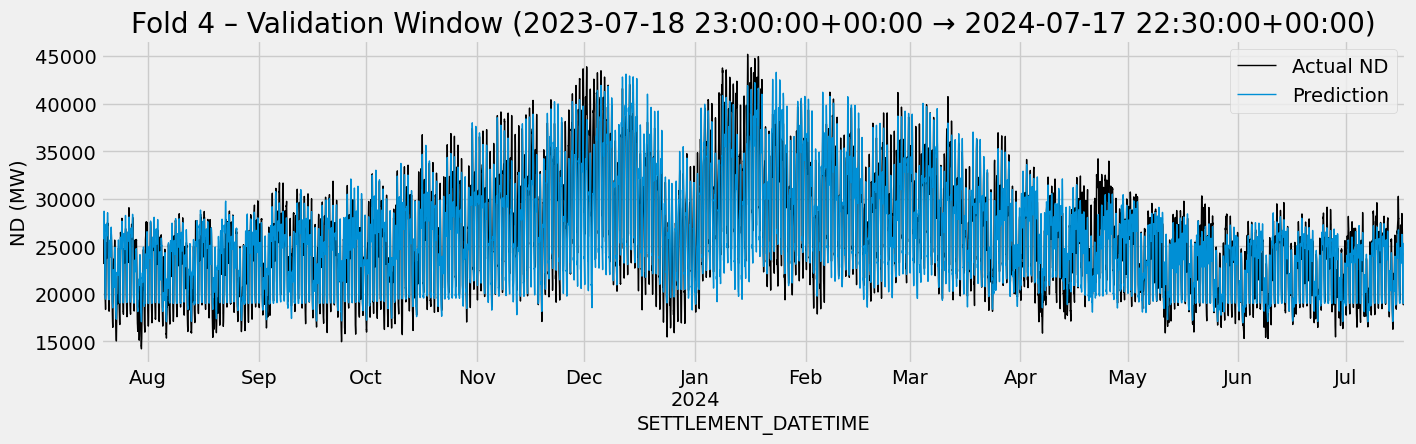

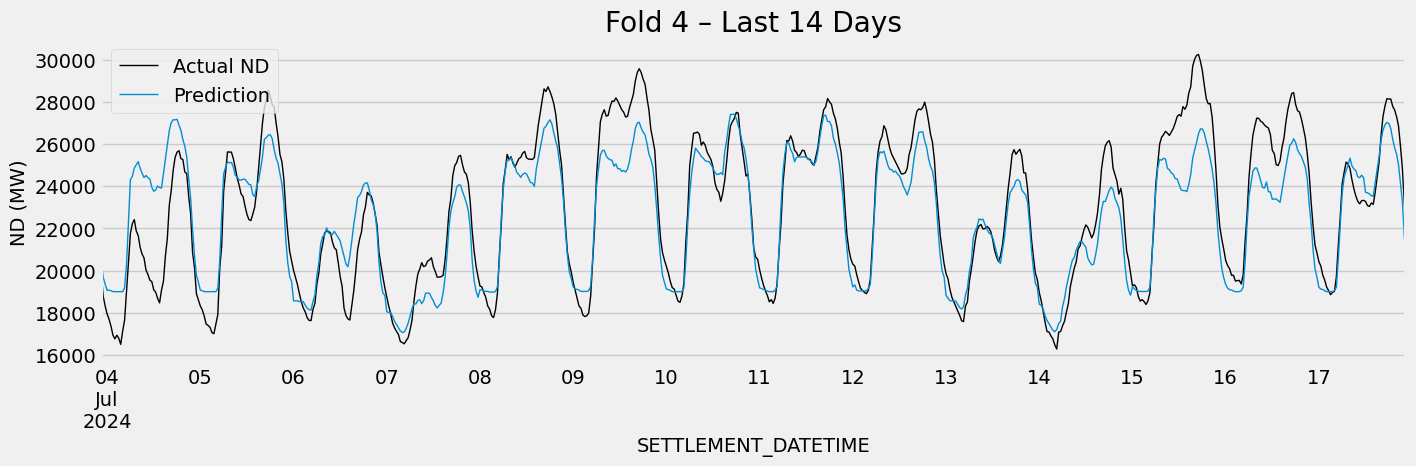

[0]	validation_0-rmse:34450.04890	validation_1-rmse:26716.41016
[100]	validation_0-rmse:13027.71063	validation_1-rmse:10386.64533
[200]	validation_0-rmse:5506.84466	validation_1-rmse:4895.34946
[300]	validation_0-rmse:3200.61186	validation_1-rmse:3340.59546
[400]	validation_0-rmse:2588.67953	validation_1-rmse:2887.11203
[500]	validation_0-rmse:2406.96658	validation_1-rmse:2760.53239
[600]	validation_0-rmse:2318.50496	validation_1-rmse:2725.99254
[700]	validation_0-rmse:2258.33675	validation_1-rmse:2710.41447
[800]	validation_0-rmse:2205.32119	validation_1-rmse:2695.65298
[900]	validation_0-rmse:2162.70014	validation_1-rmse:2686.20577
[999]	validation_0-rmse:2127.23202	validation_1-rmse:2681.86205
Fold 5: RMSE=2681.13, MAPE=7.83%


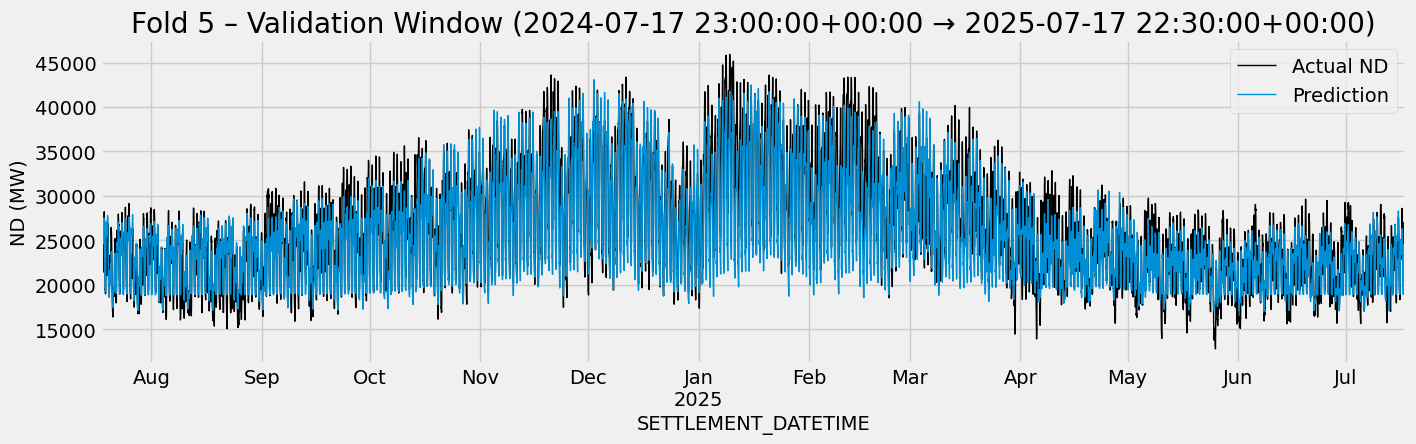

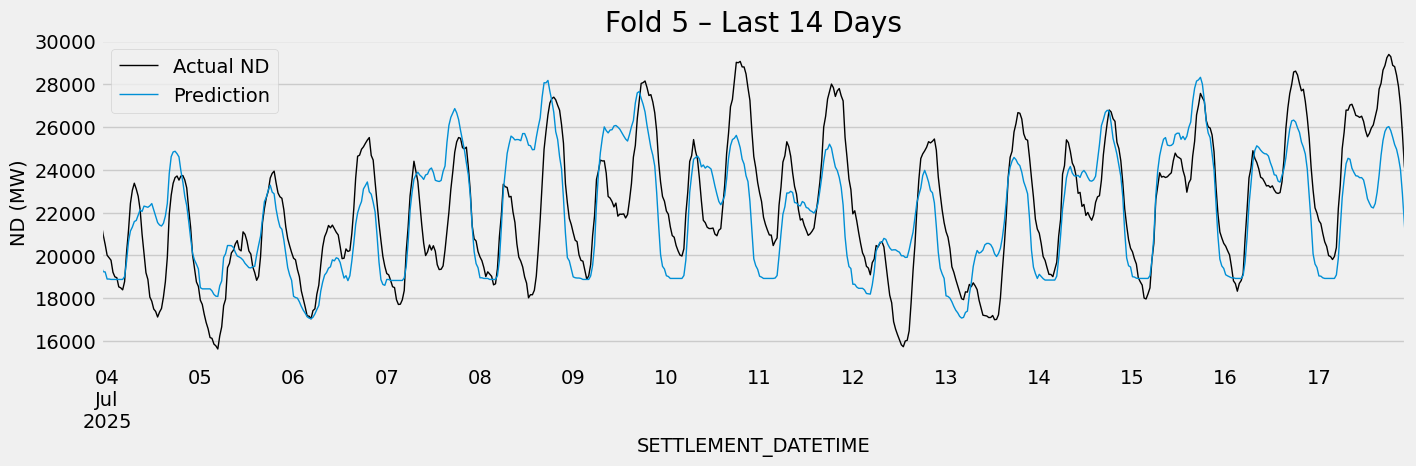

In [31]:
YEAR = 17520    # 17,532 can be used for full year as 17520 is not accounting for leap years but as neither 2025 
                # or 2026 are leap years this will keep the years we are looking at specifically aligned
GAP  = 48       # 48*30 when using rolling averages up to a month (30 days)

tss = TimeSeriesSplit(n_splits=5, test_size=YEAR, gap=GAP)

df = df.sort_index()

# container for OOF predictions (same index as df)
oof_pred = pd.Series(index=df.index, dtype=float, name='prediction')
fold_rmses = []
fold_mapes = []
scores = []
feature_importance_list = []

fold = 1
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx].copy()
    test  = df.iloc[val_idx].copy()
    
    

    # features
    train = create_calendar_features(train)
    test  = create_calendar_features(test)

    FEATURES = [
        'day_of_week','is_weekend','quarter','month','year',
        'day_of_year','day_of_month','week_of_year','settlement_period',
        'ND_exactly_1_years_ago','ND_exactly_2_years_ago','ND_exactly_3_years_ago',
        'ND_exactly_4_years_ago','ND_exactly_5_years_ago',
        'sp_sin', 'sp_cos', 'is_holiday'
    ]
    TARGET = 'ND'
    
    cols = FEATURES + [TARGET]
    train_ = train[cols].dropna()
    test_  = test[cols].dropna()

    X_train, y_train = train[FEATURES], train[TARGET]
    X_test,  y_test  = test[FEATURES],  test[TARGET]

    reg = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=3,
        objective='reg:squarederror',
        booster='gbtree',
        base_score=0.5,
        early_stopping_rounds=50
    )
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

    y_pred = reg.predict(X_test)
    oof_pred.loc[X_test.index] = y_pred

    # fold metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(rmse)
    mape = ((np.abs(y_pred - y_test) / y_test).replace([np.inf, -np.inf], np.nan).dropna()).mean() * 100
    fold_rmses.append(rmse)
    fold_mapes.append(mape)

    print(f"Fold {fold}: RMSE={rmse:.2f}, MAPE={mape:.2f}%")

    # Store feature importance
    fold_importance = pd.DataFrame({
        'feature': FEATURES,
        'importance': reg.feature_importances_,
        'fold': fold
    })
    feature_importance_list.append(fold_importance)
    
    # hash if plotting folds
    #fold += 1

    # ---------- PLOTS FOR THIS FOLD ----------
    val_plot = pd.DataFrame({'ND': y_test, 'pred': y_pred}, index=X_test.index)

    # 1) Full validation window
    fig, ax = plt.subplots(figsize=(15, 4))
    val_plot['ND'].plot(ax=ax, lw=1, label='Actual ND', color='black')
    val_plot['pred'].plot(ax=ax, lw=1, label='Prediction')
    ax.set_title(f'Fold {fold} – Validation Window ({val_plot.index.min()} → {val_plot.index.max()})')
    ax.set_ylabel('ND (MW)')
    ax.legend()
    plt.show()

    # 2) Zoom: last 14 days of the fold
    zoom_start = val_plot.index.max() - pd.Timedelta(days=14)
    val_zoom = val_plot.loc[zoom_start:]
    fig, ax = plt.subplots(figsize=(15, 4))
    val_zoom['ND'].plot(ax=ax, lw=1, label='Actual ND', color='black')
    val_zoom['pred'].plot(ax=ax, lw=1, label='Prediction')
    ax.set_title(f'Fold {fold} – Last 14 Days')
    ax.set_ylabel('ND (MW)')
    ax.legend()
    plt.show()

    # unhash if plotting folds
    fold += 1

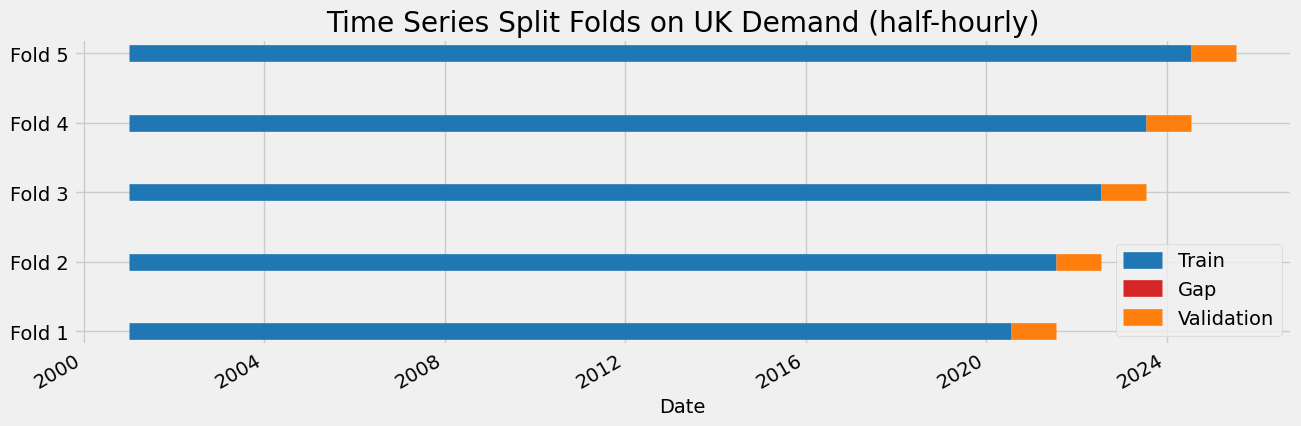

In [32]:
# Extract parameters from your existing TSS object
n_splits = tss.n_splits
test_size = tss.test_size
gap = tss.gap

idx = df.index

title = "Time Series Split Folds on UK Demand (half-hourly)"
fig, ax = plt.subplots(figsize=(14, 0.5*n_splits + 2))
for fold, (train_idx, test_idx) in enumerate(tss.split(df), start=1):
    y = fold

    # Train span
    ax.hlines(y, idx[train_idx[0]], idx[train_idx[-1]],
              colors='tab:blue', linewidth=12, label='Train' if fold == 1 else None)

    # Gap span (if any)
    # There is a gap if the first test index is beyond the last train index + 1
    if test_idx[0] - train_idx[-1] > 1:
        gap_start = idx[train_idx[-1] + 1]
        gap_end   = idx[test_idx[0] - 1]
        ax.hlines(y, gap_start, gap_end,
                  colors='tab:red', linewidth=12, label='Gap' if fold == 1 else None)

    # Validation/Test span
    ax.hlines(y, idx[test_idx[0]], idx[test_idx[-1]],
              colors='tab:orange', linewidth=12, label='Validation' if fold == 1 else None)

ax.set_yticks(range(1, n_splits + 1))
ax.set_yticklabels([f'Fold {i}' for i in range(1, n_splits + 1)])
ax.set_xlabel('Date')
ax.set_title(title or f"TimeSeriesSplit (test_size={test_size}, gap={gap})")
ax.legend(loc='lower right')
fig.autofmt_xdate()
plt.show()

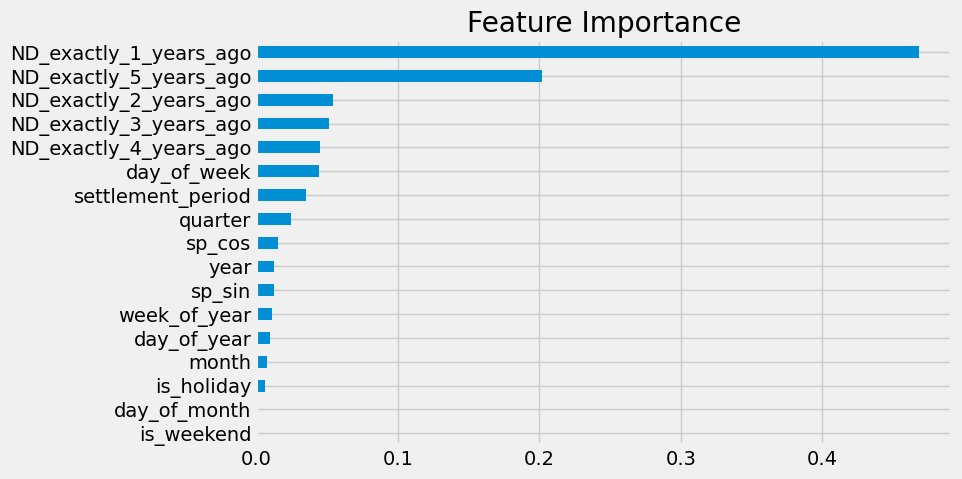

                        importance
is_weekend                0.000000
day_of_month              0.000000
is_holiday                0.006050
month                     0.007478
day_of_year               0.009818
week_of_year              0.011311
sp_sin                    0.012190
year                      0.012739
sp_cos                    0.015180
quarter                   0.024464
settlement_period         0.035362
day_of_week               0.044409
ND_exactly_4_years_ago    0.044621
ND_exactly_3_years_ago    0.051564
ND_exactly_2_years_ago    0.054501
ND_exactly_5_years_ago    0.201879
ND_exactly_1_years_ago    0.468434
importance    1.0
dtype: float32


In [33]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi_sorted = fi.sort_values('importance')

fi_sorted.plot(kind='barh', title='Feature Importance', legend=False, figsize=(8,5))
plt.show()

# Print sorted DataFrame
print(fi_sorted)
print(fi_sorted.sum())

In [34]:
pred_df = pd.DataFrame({'ND': df['ND'], 'prediction': oof_pred})

# keep rows that have both truth and prediction
valid = pred_df['ND'].notna() & pred_df['prediction'].notna()
y_true = pred_df.loc[valid, 'ND']
y_pred = pred_df.loc[valid, 'prediction']

# core errors
err   = y_pred - y_true
mae   = np.mean(np.abs(err))
rmse  = np.sqrt(np.mean(err**2))
nrmse = rmse / y_true.mean()

# % errors — guard against divide-by-zero
eps = 1e-6
nonzero = y_true.abs() > eps
mape  = (np.abs(err[nonzero]) / y_true[nonzero]).mean() * 100

den = (y_true.abs() + y_pred.abs())
valid_den = den > eps
smape = (200 * (np.abs(err[valid_den]) / den[valid_den])).mean()

print(f"Used {valid.sum():,} OOF points for metrics (out of {len(pred_df):,}).")
print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | nRMSE: {nrmse:.4f}")
print(f"MAPE: {mape:.2f}% | SMAPE: {smape:.2f}%")

print(f"Fold RMSEs: {[round(s,2) for s in scores]} | Mean RMSE: {np.mean(scores):.2f}")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, nRMSE: {nrmse:.4f}, SMAPE: {smape:.2f}%")

Used 87,600 OOF points for metrics (out of 430,270).
MAE: 1986.56 | RMSE: 2565.70 | nRMSE: 0.0956
MAPE: 7.48% | SMAPE: 7.56%
Fold RMSEs: [3262.89, 2163.03, 2296.5, 2264.19, 2681.13] | Mean RMSE: 2533.55
MAE: 1986.56, RMSE: 2565.70, nRMSE: 0.0956, SMAPE: 7.56%


In [35]:
err = y_pred - y_true

# Weighted MAPE (stable when values vary a lot)
wmape = (np.abs(err).sum() / np.abs(y_true).sum()) * 100

# Normalised RMSE by mean ND
nrmse_overall = np.sqrt(np.mean(err**2)) / y_true.mean()

print(f"wMAPE: {wmape:.2f}% | nRMSE: {nrmse_overall:.4f}")

# nRMSE by month
nrmse_by_month = (
    pd.DataFrame({'y_true': y_true, 'err': err})
    .groupby(y_true.index.month)
    .apply(lambda g: np.sqrt(np.mean(g['err']**2)) / g['y_true'].mean())
)
print("\nNormalised RMSE by Month:")
print(nrmse_by_month)

# nRMSE by settlement period
nrmse_by_sp = (
    pd.DataFrame({'y_true': y_true, 'err': err})
    .groupby(y_true.index.hour * 2 + (y_true.index.minute // 30) + 1)
    .apply(lambda g: np.sqrt(np.mean(g['err']**2)) / g['y_true'].mean())
)
print("\nNormalised RMSE by Settlement Period:")
print(nrmse_by_sp)

wMAPE: 7.40% | nRMSE: 0.0956

Normalised RMSE by Month:
SETTLEMENT_DATETIME
1     0.100992
2     0.098358
3     0.086287
4     0.118043
5     0.122069
6     0.100618
7     0.092156
8     0.077943
9     0.074588
10    0.079697
11    0.081281
12    0.096173
dtype: float64

Normalised RMSE by Settlement Period:
SETTLEMENT_DATETIME
1     0.091385
2     0.093191
3     0.094459
4     0.096325
5     0.098590
6     0.099592
7     0.101016
8     0.101687
9     0.098305
10    0.094973
11    0.092879
12    0.093023
13    0.094496
14    0.096873
15    0.097410
16    0.096496
17    0.095039
18    0.095428
19    0.096825
20    0.099579
21    0.102795
22    0.105937
23    0.108859
24    0.111668
25    0.114037
26    0.115900
27    0.116227
28    0.115121
29    0.113087
30    0.109656
31    0.103199
32    0.095104
33    0.087639
34    0.082137
35    0.077378
36    0.074455
37    0.072691
38    0.074415
39    0.075819
40    0.078159
41    0.079749
42    0.083067
43    0.085467
44    0.088065
45    0.08

In [36]:
print("Any NaNs left in OOF preds?", oof_pred.isna().any())
missing_in_oof = df.index.difference(oof_pred.dropna().index)
print("Rows without OOF preds (earliest train-only etc.):", len(missing_in_oof))

Any NaNs left in OOF preds? True
Rows without OOF preds (earliest train-only etc.): 342670


In [37]:
df = df.join(oof_pred)   # guarantees a 'prediction' column

In [38]:
# Make DataFrame with OOF predictions and actuals
errors_df = df.copy()
errors_df['prediction'] = oof_pred
errors_df = errors_df.dropna(subset=['prediction'])  # only rows that have predictions

# Error columns
errors_df['error'] = errors_df['prediction'] - errors_df['ND']
errors_df['abs_error'] = errors_df['error'].abs()
errors_df['pct_error'] = errors_df['error'] / errors_df['ND'] * 100
errors_df['abs_pct_error'] = errors_df['pct_error'].abs()

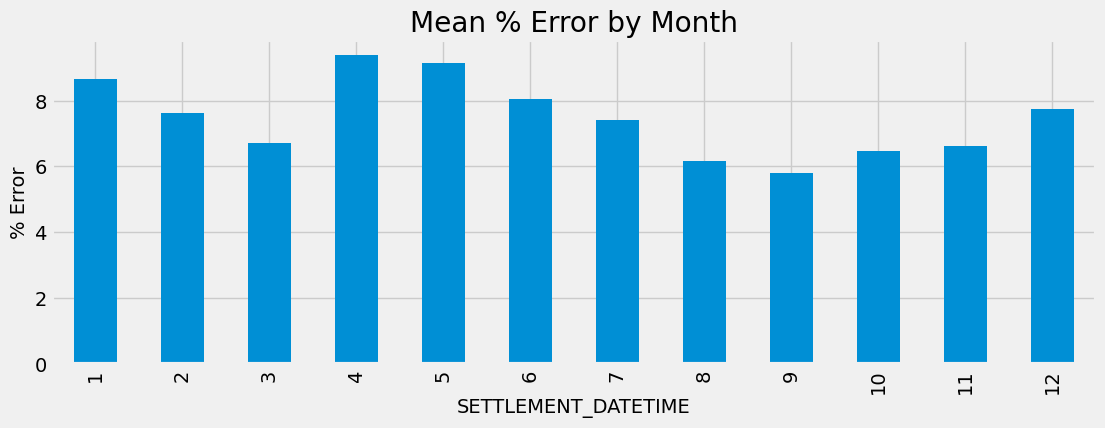

In [39]:
error_by_month = errors_df.groupby(errors_df.index.month).agg(
    mean_error=('error', 'mean'),
    mean_abs_error=('abs_error', 'mean'),
    mean_abs_pct_error=('abs_pct_error', 'mean')
)

error_by_month['mean_abs_pct_error'].plot(kind='bar', figsize=(12,4), title="Mean % Error by Month")
plt.ylabel('% Error'); plt.show()

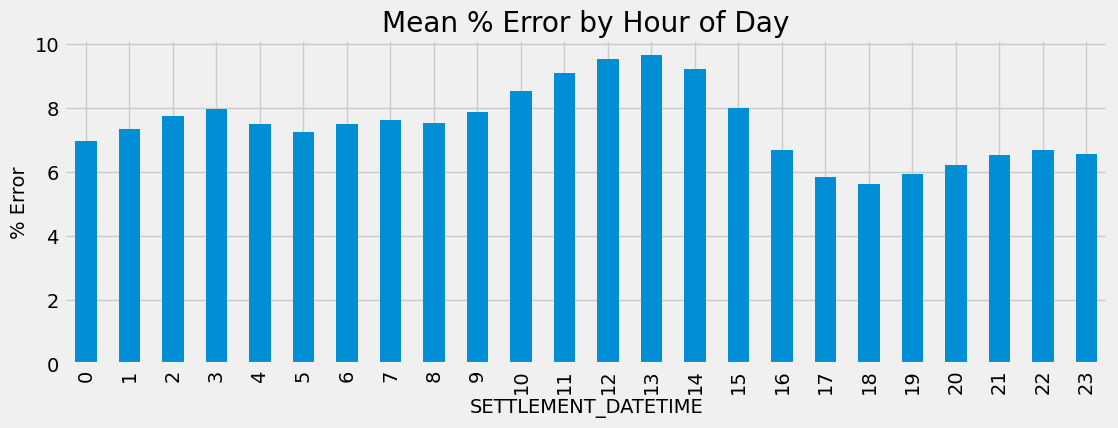

In [40]:
error_by_hour = errors_df.groupby(errors_df.index.hour).agg(
    mean_error=('error', 'mean'),
    mean_abs_error=('abs_error', 'mean'),
    mean_abs_pct_error=('abs_pct_error', 'mean')
)

error_by_hour['mean_abs_pct_error'].plot(kind='bar', figsize=(12,4), title="Mean % Error by Hour of Day")
plt.ylabel('% Error'); plt.show()

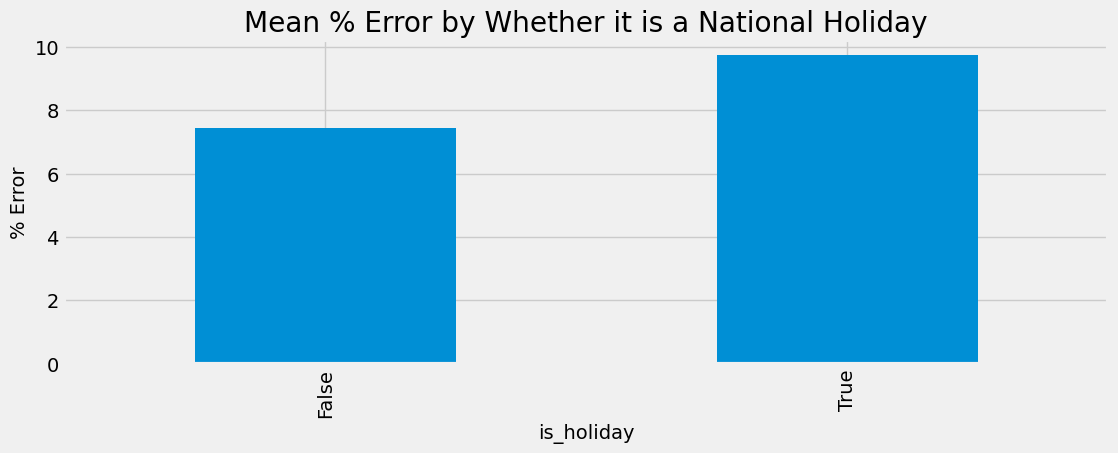

In [41]:
error_by_holiday = errors_df.groupby('is_holiday').agg(
    mean_error=('error', 'mean'),
    mean_abs_error=('abs_error', 'mean'),
    mean_abs_pct_error=('abs_pct_error', 'mean')
)

error_by_holiday['mean_abs_pct_error'].plot(kind='bar', figsize=(12,4), title="Mean % Error by Whether it is a National Holiday")
plt.ylabel('% Error'); plt.show()


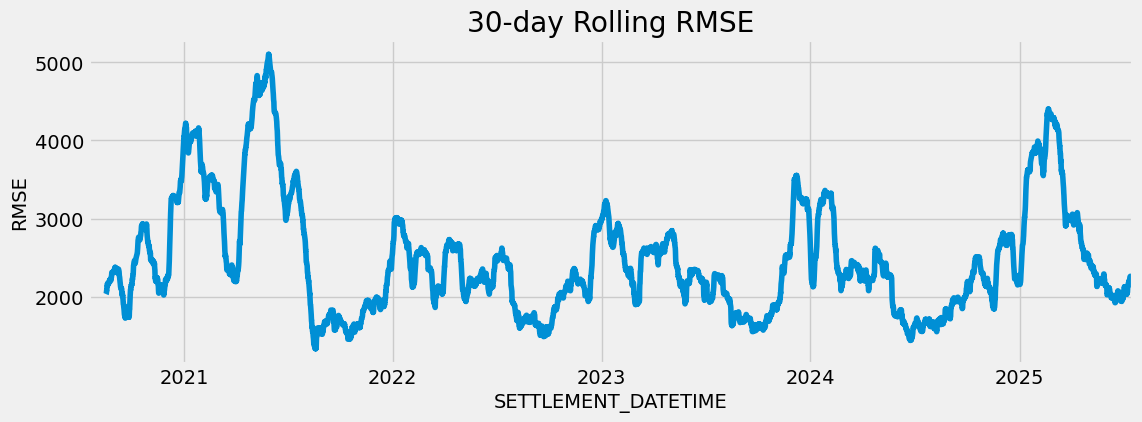

In [42]:
# residuals = actual - predicted
residuals = pred_df['ND'] - pred_df['prediction']

# --- Rolling RMSE ---
window_size = 48 * 30  # 30 days if half-hourly
rolling_rmse = (
    residuals
    .dropna()
    .rolling(window=window_size)
    .apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)
)

rolling_rmse.plot(title='30-day Rolling RMSE', figsize=(12,4))
plt.ylabel('RMSE')
plt.show()

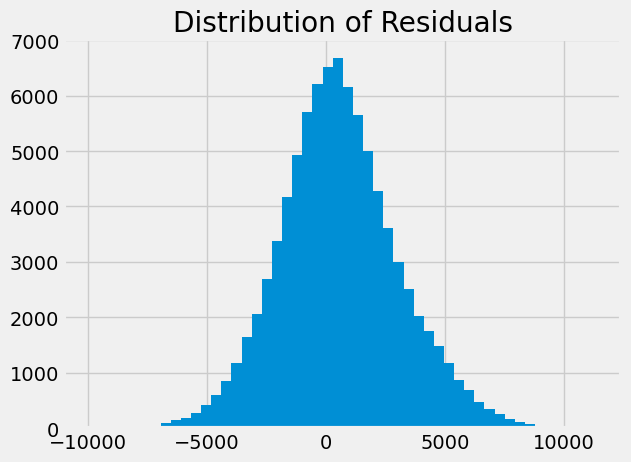

In [43]:
# --- Residual histogram ---
residuals.hist(bins=50)
plt.title("Distribution of Residuals")
plt.show()

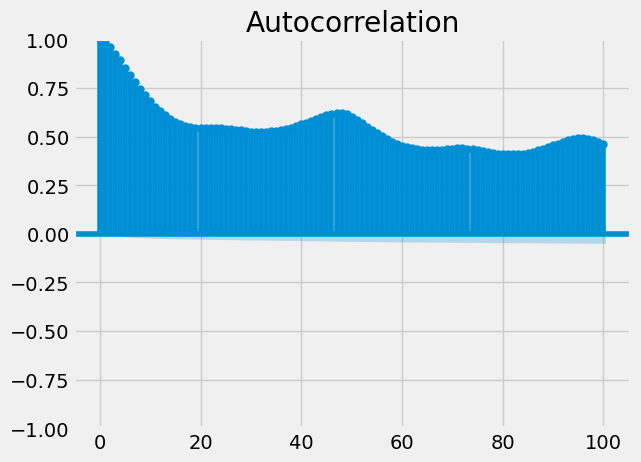

In [44]:
# --- Residual autocorrelation ---
plot_acf(residuals.dropna(), lags=100)
plt.show()

In [45]:
df.tail()

ND  hour  minute  day_of_week  is_weekend  \
SETTLEMENT_DATETIME                                                       
2025-07-17 20:30:00+00:00  27873    20      30            3       False   
2025-07-17 21:00:00+00:00  27035    21       0            3       False   
2025-07-17 21:30:00+00:00  25710    21      30            3       False   
2025-07-17 22:00:00+00:00  24176    22       0            3       False   
2025-07-17 22:30:00+00:00  23467    22      30            3       False   

                           quarter  month  year  day_of_year  day_of_month  \
SETTLEMENT_DATETIME                                                          
2025-07-17 20:30:00+00:00        3      7  2025          198            17   
2025-07-17 21:00:00+00:00        3      7  2025          198            17   
2025-07-17 21:30:00+00:00        3      7  2025          198            17   
2025-07-17 22:00:00+00:00        3      7  2025          198            17   
2025-07-17 22:30:00+00:00        3      7  2025          198            17   

                           ...    sp_sin    sp_cos holiday_name  is_holiday  \
SETTLEMENT_DATETIME        ...                                                
2025-07-17 20:30:00+00:00  ... -0.707107  0.707107         None       False   
2025-07-17 21:00:00+00:00  ... -0.608761  0.793353         None       False   
2025-07-17 21:30:00+00:00  ... -0.500000  0.866025         None       False   
2025-07-17 22:00:00+00:00  ... -0.382683  0.923880         None       False   
2025-07-17 22:30:00+00:00  ... -0.258819  0.965926         None       False   

                           ND_exactly_1_years_ago ND_exactly_2_years_ago  \
SETTLEMENT_DATETIME                                                        
2025-07-17 20:30:00+00:00                 26862.0                25193.0   
2025-07-17 21:00:00+00:00                 25908.0                24469.0   
2025-07-17 21:30:00+00:00                 24826.0                23814.0   
2025-07-17 22:00:00+00:00                 23194.0                22155.0   
2025-07-17 22:30:00+00:00                 21835.0                21326.0   

                           ND_exactly_3_years_ago  ND_exactly_4_years_ago  \
SETTLEMENT_DATETIME                                                         
2025-07-17 20:30:00+00:00                 25507.0                 26289.0   
2025-07-17 21:00:00+00:00                 25087.0                 25745.0   
2025-07-17 21:30:00+00:00                 24150.0                 24998.0   
2025-07-17 22:00:00+00:00                 23012.0                 23971.0   
2025-07-17 22:30:00+00:00                 21883.0                 22630.0   

                           ND_exactly_5_years_ago    prediction  
SETTLEMENT_DATETIME                                              
2025-07-17 20:30:00+00:00                 26585.0  24548.068359  
2025-07-17 21:00:00+00:00                 25977.0  24009.117188  
2025-07-17 21:30:00+00:00                 24850.0  22877.816406  
2025-07-17 22:00:00+00:00                 23315.0  21493.593750  
2025-07-17 22:30:00+00:00                 21846.0  20164.890625  

[5 rows x 23 columns]

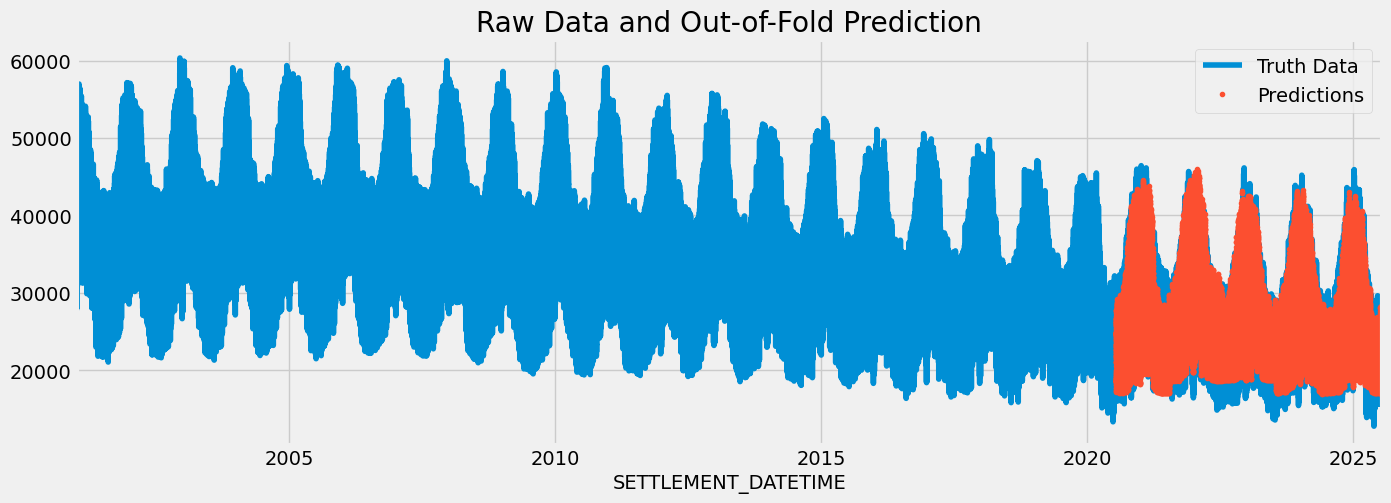

In [46]:
ax = df[['ND']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Out-of-Fold Prediction')
plt.show()

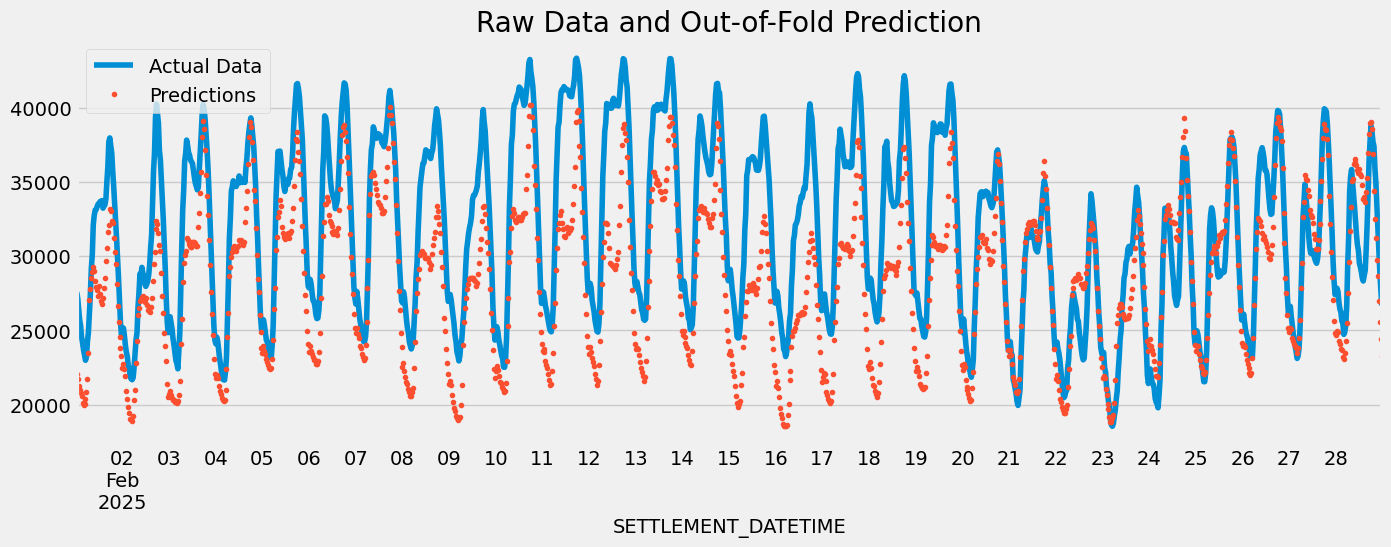

In [47]:
ax = df.loc[(df.index > '2025-02-01') & (df.index < '2025-03-01')]['ND'].plot(figsize=(15,5))
df.loc[(df.index > '2025-02-01') & (df.index < '2025-03-01')]['prediction'].plot(ax=ax, style='.')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Raw Data and Out-of-Fold Prediction')
plt.show()

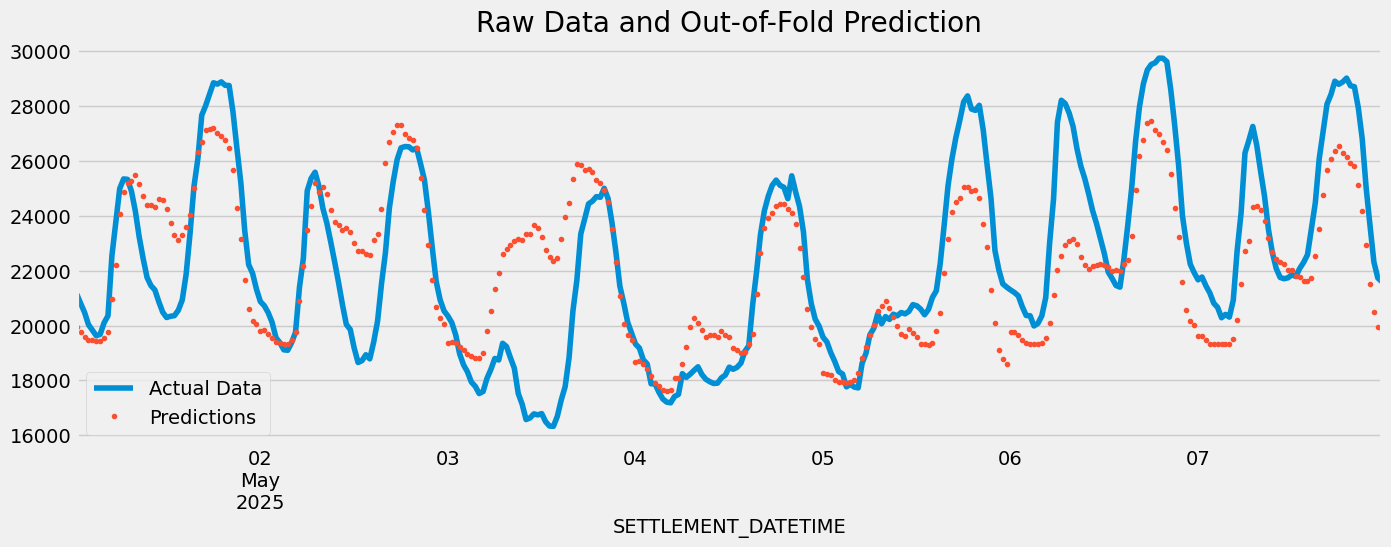

In [48]:
ax = df.loc[(df.index > '2025-05-01') & (df.index < '2025-05-08')]['ND'].plot(figsize=(15,5))
df.loc[(df.index > '2025-05-01') & (df.index < '2025-05-08')]['prediction'].plot(ax=ax, style='.')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Raw Data and Out-of-Fold Prediction')
plt.show()

In [49]:
# keep freq + tz consistent with your history
freq = pd.infer_freq(df.index) or '30min'
step = pd.tseries.frequencies.to_offset(freq)

# start one step after your last observed timestamp
start = df.index.max() + step

# end exactly one calendar year after start (handles leap years & DST)
end = start + pd.DateOffset(years=1)

# build future timeline; exclude the end instant itself
future = pd.date_range(start=start, end=end, freq=freq, inclusive='left')

future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True

df = df.copy()
df['isFuture'] = False

df_and_future = pd.concat([df, future_df])
df_and_future = create_calendar_features(df_and_future)
df_and_future = add_calendar_lags(df_and_future)

In [50]:
future_w_features = df_and_future.query('isFuture').copy()

In [51]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

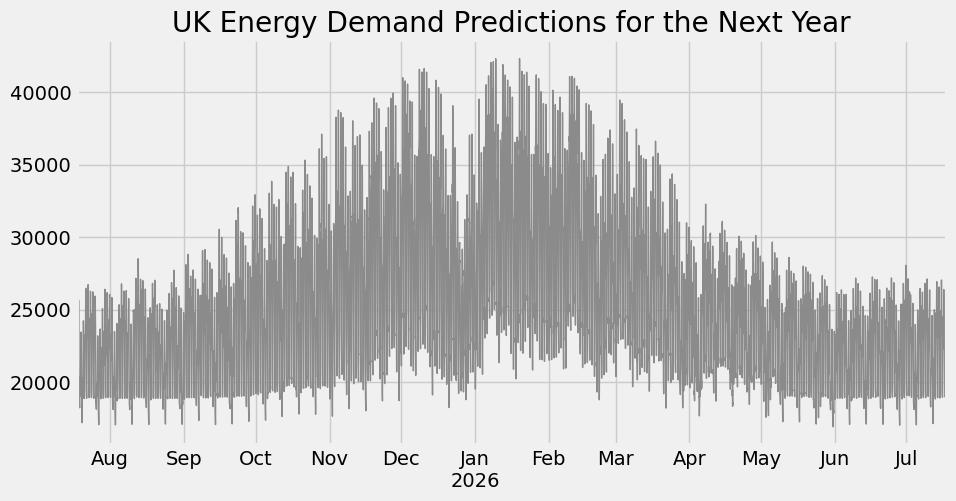

In [61]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='UK Energy Demand Predictions for the Next Year')
plt.show()

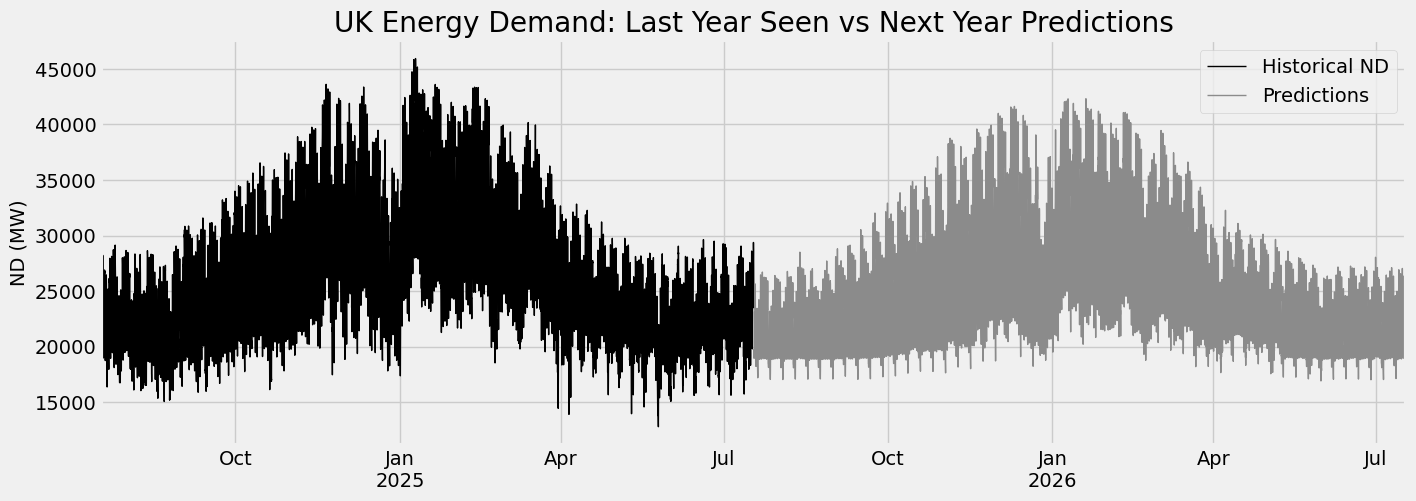

In [54]:
# 1) Get the last year of historical ND
last_year_start = df.index.max() - pd.DateOffset(years=1)
history_last_year = df.loc[last_year_start:].copy()

# 2) Combine with only the predictions for the future
plot_df = pd.concat([history_last_year[['ND']], future_w_features[['pred']]])

# 3) Plot
fig, ax = plt.subplots(figsize=(15, 5))

# Historical ND
plot_df['ND'].plot(ax=ax, color='black', lw=1, label='Historical ND')

# Future predictions
plot_df['pred'].plot(ax=ax, color=color_pal[4], lw=1, label='Predictions')

ax.set_title('UK Energy Demand: Last Year Seen vs Next Year Predictions')
ax.set_ylabel('ND (MW)')
ax.legend()
plt.show()

In [74]:
# --- Improvement 7: Residual-based Prediction Intervals ---

# 1) Compute residuals by settlement period (or month+sp for finer bands)
grp = errors_df.groupby('settlement_period')['error']

# 10th and 90th percentiles of errors
q_lo = grp.quantile(0.05)
q_hi = grp.quantile(0.95)

# 2) Apply to future predictions
sp_future = future_w_features['settlement_period']
future_w_features['pred_p05'] = future_w_features['pred'] + sp_future.map(q_lo).values
future_w_features['pred_p95'] = future_w_features['pred'] + sp_future.map(q_hi).values

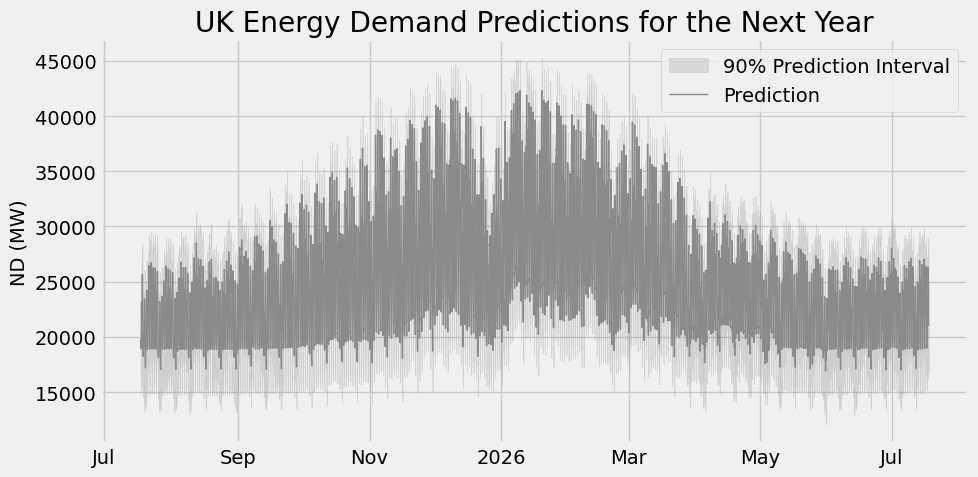

In [76]:
# 1) Keep only the rows where all three series exist
band = future_w_features[['pred', 'pred_p05', 'pred_p95']].dropna().copy()

# 2) Ensure index is sorted and timezone-naive (matplotlib is picky here)
band = band.sort_index()
if band.index.tz is not None:
    x = band.index.tz_convert(None).to_pydatetime()
else:
    x = band.index.to_pydatetime()

# 3) Make sure lower <= upper (swap if needed)
low  = np.minimum(band['pred_p05'].values, band['pred_p95'].values)
high = np.maximum(band['pred_p05'].values, band['pred_p95'].values)

# 4) Plot
fig, ax = plt.subplots(figsize=(10, 5))

# Shaded interval
ax.fill_between(x, low, high, alpha=0.2, color='gray', label='90% Prediction Interval')

# Forecast line
ax.plot(x, band['pred'].values, lw=1, color=color_pal[4], label='Prediction')

# Nice date formatting
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_title('UK Energy Demand Predictions for the Next Year')
ax.set_ylabel('ND (MW)')
ax.legend()
plt.tight_layout()
plt.show()

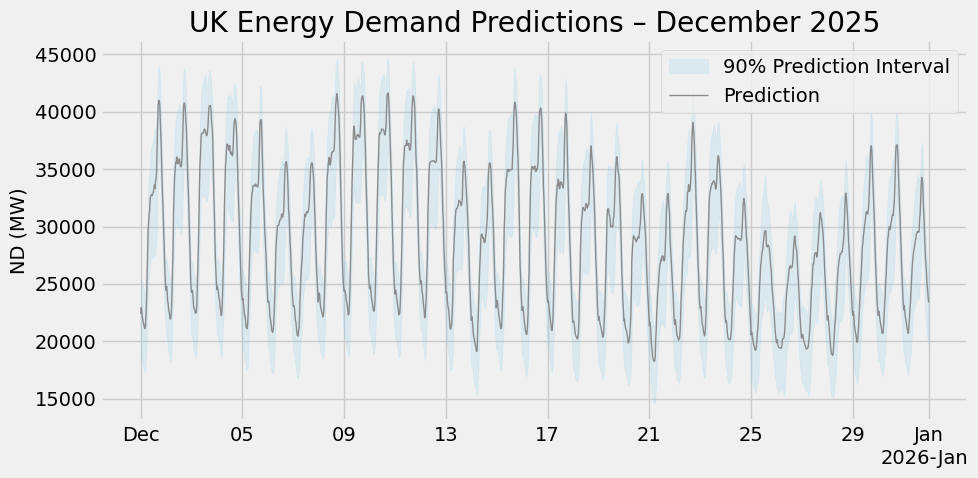

In [77]:
# Filter for December 2025
band = future_w_features[['pred', 'pred_p05', 'pred_p95']].dropna().copy()
band = band.loc['2025-12-01':'2025-12-31']

# Ensure index sorted and timezone-naive
band = band.sort_index()
if band.index.tz is not None:
    x = band.index.tz_convert(None).to_pydatetime()
else:
    x = band.index.to_pydatetime()

# Ensure lower <= upper
low  = np.minimum(band['pred_p05'].values, band['pred_p95'].values)
high = np.maximum(band['pred_p05'].values, band['pred_p95'].values)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

# Shaded interval
ax.fill_between(x, low, high, alpha=0.2, color='skyblue', label='90% Prediction Interval')

# Forecast line
ax.plot(x, band['pred'].values, lw=1, color=color_pal[4], label='Prediction')

# Date formatting
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_title('UK Energy Demand Predictions – December 2025')
ax.set_ylabel('ND (MW)')
ax.legend()
plt.tight_layout()
plt.show()
